

Model Comparisons


### Data set
The BMI data will be utilized. Recall:  
* _MI_ files contain data with the number of spikes for 48 neurons, at mutliple time points, for a single fold. There are 20 folds (20 files), where each fold consists of over 1000 times points (the rows). At each time point, we record the number of spikes for each neuron for 20 bins. Therefore, each time point has 48 * 20 = 960 columns.  
* _theta_ files record the angular position of the shoulder (in column 0) and the elbow (in column 1) for each time point. (rad)
* _dtheta_ files record the angular velocity of the shoulder (in column 0) and the elbow (in column 1) for each time point.  (rad/s)
* _torque_ files record the torque of the shoulder (in column 0) and the elbow (in column 1) for each time point. (N-m)
* _time_ files record the actual time stamp of each time point.  


### Objectives
* Understanding regularization using __holistic cross validation__
* Training set size sensitivity analysis
* Model selection



### General References
* [Guide to Jupyter](https://www.datacamp.com/community/tutorials/tutorial-jupyter-notebook)
* [Python Built-in Functions](https://docs.python.org/3/library/functions.html)
* [Python Data Structures](https://docs.python.org/3/tutorial/datastructures.html)
* [Numpy Reference](https://docs.scipy.org/doc/numpy/reference/index.html)
* [Numpy Cheat Sheet](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Numpy_Python_Cheat_Sheet.pdf)
* [Summary of matplotlib](https://matplotlib.org/3.1.1/api/pyplot_summary.html)
* [DataCamp: Matplotlib](https://www.datacamp.com/community/tutorials/matplotlib-tutorial-python?utm_source=adwords_ppc&utm_campaignid=1565261270&utm_adgroupid=67750485268&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=1t1&utm_creative=332661264365&utm_targetid=aud-299261629574:dsa-473406587955&utm_loc_interest_ms=&utm_loc_physical_ms=9026223&gclid=CjwKCAjw_uDsBRAMEiwAaFiHa8xhgCsO9wVcuZPGjAyVGTitb_-fxYtkBLkQ4E_GjSCZFVCqYCGkphoCjucQAvD_BwE)
* [Pandas DataFrames](https://urldefense.proofpoint.com/v2/url?u=https-3A__pandas.pydata.org_pandas-2Ddocs_stable_reference_api_pandas.DataFrame.html&d=DwMD-g&c=qKdtBuuu6dQK9MsRUVJ2DPXW6oayO8fu4TfEHS8sGNk&r=9ngmsG8rSmDSS-O0b_V0gP-nN_33Vr52qbY3KXuDY5k&m=mcOOc8D0knaNNmmnTEo_F_WmT4j6_nUSL_yoPmGlLWQ&s=h7hQjqucR7tZyfZXxnoy3iitIr32YlrqiFyPATkW3lw&e=)
* [Sci-kit Learn Linear Models](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model)
* [Sci-kit Learn Ensemble Models](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble)
* [Sci-kit Learn Metrics](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)
* [Sci-kit Learn Model Selection](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection)
* [SciPy Paired t-test for Dependent Samples](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.ttest_rel.html)
* [Student's t-test](https://en.wikipedia.org/wiki/Student%27s_t-test#Dependent_t-test_for_paired_samples)
* [Understanding Paired t-tests](https://machinelearningmastery.com/how-to-code-the-students-t-test-from-scratch-in-python/)



In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import os, re, fnmatch
import pathlib, itertools, time
import matplotlib.pyplot as plt
import joblib
import warnings
warnings.filterwarnings("ignore")

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import explained_variance_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet


FIGW = 10
FIGH = 6
FONTSIZE = 12

HOME_DIR = pathlib.Path.home()

plt.rcParams['figure.figsize'] = (FIGW, FIGH)
plt.rcParams['font.size'] = FONTSIZE

plt.rcParams['xtick.labelsize'] = FONTSIZE
plt.rcParams['ytick.labelsize'] = FONTSIZE

%matplotlib inline

/opt/oscer/software/SciPy-bundle/2019.11-foss-2019a-Python-3.8.0/lib/python3.8/site-packages/scipy/optimize/_shgo.py:495: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if cons['type'] is 'ineq':
/opt/oscer/software/SciPy-bundle/2019.11-foss-2019a-Python-3.8.0/lib/python3.8/site-packages/scipy/optimize/_shgo.py:743: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(self.X_min) is not 0:


In [2]:
"""
Display current working directory of this notebook. If you are using 
relative paths for your data, then it needs to be relative to the CWD.
"""
pathlib.Path.cwd()

PosixPath('/home/csdsa597018/sai_HW')

# LOAD DATA

In [3]:
def read_bmi_file_set(directory, filebase):
    '''
    Read a set of CSV files and append them together
    :param directory: The directory in which to scan for the CSV files
    :param filebase: File specification potentially including wildcards
    :returns: A list of Numpy arrays (one for each fold)
    '''
    
    # The set of files in the directory
    files = fnmatch.filter(os.listdir(directory), filebase)
    files.sort()

    # Create list of Pandas objects; 
    # Each from a file in the directory matching the filebase
    lst = [pd.read_csv(directory + "/" + file, delim_whitespace=True).values 
           for file in files]
    
    # Concatenate the Pandas objects together. ignore_index is 
    # critical here so that the duplicate row indices are addressed
    return lst

In [4]:
""" PROVIDED
Load the BMI data from all the folds, using read_bmi_file_set()
"""
# TODO: might need to change directory
dir_name = '../mlp_2020/datasets/bmi/DAT6_08'

MI_folds = read_bmi_file_set(dir_name, 'MI_fold*')
theta_folds = read_bmi_file_set(dir_name, 'theta_fold*')
dtheta_folds = read_bmi_file_set(dir_name, 'dtheta_fold*')
torque_folds = read_bmi_file_set(dir_name, 'torque_fold*')
time_folds = read_bmi_file_set(dir_name, 'time_fold*')

alldata_folds = zip(MI_folds, theta_folds, dtheta_folds, 
                    torque_folds, time_folds)

nfolds = len(MI_folds)
nfolds

20

In [5]:
""" PROVIDED
Print out the shape of all the data for each fold
"""
for i, (MI, theta, dtheta, torque, time) in enumerate(alldata_folds):
    print("FOLD %2d " % i, MI.shape, theta.shape, 
          dtheta.shape, torque.shape, time.shape)

FOLD  0  (1193, 960) (1193, 2) (1193, 2) (1193, 2) (1193, 1)
FOLD  1  (1104, 960) (1104, 2) (1104, 2) (1104, 2) (1104, 1)
FOLD  2  (1531, 960) (1531, 2) (1531, 2) (1531, 2) (1531, 1)
FOLD  3  (1265, 960) (1265, 2) (1265, 2) (1265, 2) (1265, 1)
FOLD  4  (1498, 960) (1498, 2) (1498, 2) (1498, 2) (1498, 1)
FOLD  5  (1252, 960) (1252, 2) (1252, 2) (1252, 2) (1252, 1)
FOLD  6  (1375, 960) (1375, 2) (1375, 2) (1375, 2) (1375, 1)
FOLD  7  (1130, 960) (1130, 2) (1130, 2) (1130, 2) (1130, 1)
FOLD  8  (1247, 960) (1247, 2) (1247, 2) (1247, 2) (1247, 1)
FOLD  9  (1257, 960) (1257, 2) (1257, 2) (1257, 2) (1257, 1)
FOLD 10  (1265, 960) (1265, 2) (1265, 2) (1265, 2) (1265, 1)
FOLD 11  (1146, 960) (1146, 2) (1146, 2) (1146, 2) (1146, 1)
FOLD 12  (1225, 960) (1225, 2) (1225, 2) (1225, 2) (1225, 1)
FOLD 13  (1238, 960) (1238, 2) (1238, 2) (1238, 2) (1238, 1)
FOLD 14  (1570, 960) (1570, 2) (1570, 2) (1570, 2) (1570, 1)
FOLD 15  (1359, 960) (1359, 2) (1359, 2) (1359, 2) (1359, 1)
FOLD 16  (1579, 960) (15

# PARAMETER SET LIST

In [6]:
def generate_paramsets(param_lists):
    '''
    Construct the Cartesian product of the parameters
    PARAMS:
        params_lists: dict of lists of values to try for each parameter.
                      keys of the dict are the names of the parameters
                      values are lists of values to try for the 
                      corresponding parameter
    RETURNS: a list of dicts that make up the Cartesian product of the 
    parameters
    '''
    keys, values = zip(*param_lists.items())
    # Determines cartesian product of parameter values
    combos = itertools.product(*values)
    # Constructs list of dictionaries
    combos_dicts = [dict(zip(keys, vals)) for vals in combos]
    return list(combos_dicts)

# PERFORMANCE EVALUTION

In [7]:
def mse_rmse(trues, preds):
    '''
    Compute MSE and rMSE for each column separately.
    '''
    mse = np.sum(np.square(trues - preds), axis=0) / trues.shape[0]
    rmse = np.sqrt(mse)
    return mse, rmse

def score_eval(model, X, y, preds):
    '''
    Compute the model predictions and corresponding scores, for an
    already trained model.
    PARAMS:
        model: model to predict with
        X: input feature data
        y: true output for X
        preds: predicted output for X
    RETURNS: results as a dictionary of numpy arrays
        mse: mean squared error for each column
        rmse: rMSE for each column
        evar: explained variance, best is 1.0
        score: score computed by the models score() method
    '''
    score = model.score(X, y)

    mse, rmse = mse_rmse(y, preds)
    evar = explained_variance_score(y, preds)
    
    # Dictionary of numpy arrays. The numpy arrays must
    # be row vectors, where each element is the result 
    # for a different output, when using multiple regression.
    # The keys of the dictionary are the name of the performance 
    # metric, and the values are the numpy row vectors
    results = {'mse': np.reshape(mse, (1, -1)), 
               'rmse': np.reshape(rmse, (1, -1)), 
               'evar': np.reshape(evar, (1, -1)), 
               'score': np.reshape(score, (1, -1)), 
              }
    return results

# CROSS VALIDATION

In [8]:
""" PROVIDED:
    This is the same KFoldHolisticCrossValidation class from HW6.
"""
class KFoldHolisticCrossValidation():
    def __init__(self, model, paramsets, eval_func, opt_metric, 
                 maximize_opt_metric=False, trainsizes=[1], rotation_skip=1):
        ''' 
        Object for managing and performing cross validation for a given 
        model for a list of parameter sets and train set sizes. Note, 
        train set size is in terms of number of folds (not samples)
        
        General Procedure:
        + iter over hyper-parameter sets
          1. set hyper-parameters of the model
          2. iter over train set sizes
             a. iter over splits/rotations
                  i. train the model
                 ii. evaluate the model on train, val, and test sets
                iii. record the results
             b. record the results by size
          3. record the results by hyper-parameter set

        PARAMS:
            model: base ML model
            
            paramsets: list of dicts of parameter sets to give to the model
            
            eval_func: handle to function used to evaluate/score the model
                       The eval_func definition must have the following  
                       arguments: model, X, ytrue, ypreds; and return a dict 
                       of numpy arrays with shape 1-by-n, where n is the
                       number of outputs if using multiple regression.
                       template function header: 
                           def eval_func(model, X, y, preds)
                       template output: 
                           {'metrics1':1_by_n_array, ...}
                       
            opt_metric: the optimized metric. one of the metric key names 
                        returned from eval_func to use to pick the best 
                        parameter sets
                        
            maximize_opt_metric: True if opt_metric is maximized; 
                                 False if minimized
            
            trainsizes: list of training set sizes (in number of folds) to try
            
            rotation_skip: build model and evaluate every ith rotation (1=all 
                           possible rotations; 2=every other rotation, etc.)
        ''' 
        self.model = model
        self.paramsets = paramsets
        self.trainsizes = trainsizes
        self.eval_func = eval_func
        self.opt_metric = opt_metric + '_mean'
        self.maximize_opt_metric = maximize_opt_metric
        self.rotation_skip = rotation_skip
        
        # Results attributes
        # Full recording of all results for all paramsets, sizes, rotations,
        # and metrics. This is a list of dictionaries for each paramset
        self.results = None
        # Validation summary report of all means and standard deviations for 
        # all metrics, for all paramsets, and sizes. This is a 3D s-by-r-by-p 
        # numpy array. Where s is the number of sizes, r the number of summary 
        # metrics +2, and p is the number of paramsets
        self.report_by_size = None
        # List of the indices of the best paramset for each size
        self.best_param_inds = None

        
    def get_data(self, all_Xfolds, all_yfolds, nfolds, rotation, trainsize):
        '''
        Determines the fold indices for the train, val, and test set given
        the total number of folds, rotation, and training set size.
        Use these fold indices to get the training, validation, and test sets
        from all_xfolds and all_folds
        '''
        # Detrmine fold indices
        trainfolds = (np.arange(trainsize) + rotation) % nfolds
        valfold = (nfolds - 2 + rotation) % nfolds
        testfold = (valfold + 1) % nfolds
        
        # Construct train set by concatenating the individual  
        #       training folds together (hint: see np.take() and 
        #       np.concatenate())
        X = np.concatenate(np.take(all_Xfolds, trainfolds))
        y = np.concatenate(np.take(all_yfolds, trainfolds))

        # Construct validation set. Hint: this is always one fold
        Xval = all_Xfolds[valfold]
        yval = all_yfolds[valfold]

        # Construct test set
        Xtest = all_Xfolds[testfold]
        ytest = all_yfolds[testfold]
        
        return X, y, Xval, yval, Xtest, ytest

        
    def perform_cross_validation(self, all_Xfolds, all_yfolds, 
                                 trainsize):
        ''' 
        Perform cross validation for a singular train set size and single 
        hyper-parameter set, by evaluating the model's performance over 
        multiple data set rotations all of the same size.

        NOTE: This function assumes the hyper-parameters have already been 
              set in the model
            
        PARAMS:
            all_Xfolds: list containing all of the input data folds
            all_yfolds: list containing all of the output data folds
            trainsize: number of folds to use for training
            
        RETURNS: train, val, and test set results for all rotations of the 
                 data sets and the summary (i.e. the averages over all the 
                 rotations) of the results. 
                 results is a dictionary of dictionaries of r-by-n numpy 
                 arrays. Where r is the number of rotations, and n is the 
                 number of outputs from the model.
                 summary is a dictionary of dictionaries of 1-by-n numpy 
                 arrays. 

                 General form:
                     results.keys() = ['train', 'val', 'test']

                     results['train'].keys() = ['metric1', 'metric2', ...]
                     
                     results['train']['metric1'] = numpy_array
                     
                     results = 
                     {
                        'train':
                                 {
                                     'mse'      : r_by_n_numpy_array,
                                     'rmse': r_by_n_numpy_array, 
                                     ...
                                 },
                        'val'  : {...},
                        'test' : {...}
                     }
                     
                     summary = 
                     {
                        'train':
                                 {
                                     'mse_mean'      : 1_by_n_numpy_array,
                                     'mse_std'       : 1_by_n_numpy_array,
                                     'rmse_mean': 1_by_n_numpy_array, 
                                     'rmse_std' : 1_by_n_numpy_array,
                                     ...
                                 },
                        'val'  : {...},
                        'test' : {...}
                     }

                    For example, you can access the MSE results for the 
                    validation set like so:
                        results['val']['mse'] 
                    For example, you can access the summary (i.e. the average 
                    results over all the rotations) for the test set for the
                    rMSE like so:
                        summary['test']['rmse_mean']                
        '''
        
        # Verify a valid train set size was provided
        nfolds = len(all_Xfolds)
        if trainsize < 1 or trainsize > nfolds - 2: 
            err_msg = "ERROR: KFoldHolisticCrossValidation.perform_cross_validation() - "
            err_msg += "trainsize (%d) must be between 1 and nfolds (%d) - 2" % (trainsize, nfolds)
            raise ValueError(err_msg)
            
        # Verify rotation skip
        if self.rotation_skip < 1: 
            err_msg = "ERROR: KFoldHolisticCrossValidation.__init__() - "
            err_msg += "rotation_skip (%d) can't be less than 1" % self.rotation_skip
            raise ValueError(err_msg)
        
        # Set up results recording for each rotation
        results = {'train': None, 'val': None, 'test': None}
        summary = {'train': {}, 'val': {}, 'test': {}}
        
        model = self.model
        evaluate = self.eval_func
        
        print(range(0,nfolds, self.rotation_skip))
        
        # Rotate through different train, val, and test sets
        for rotation in range(0, nfolds, self.rotation_skip):
            # Determine fold indices for train, val, and test set. 
            X, y, Xval, yval,  Xtest, ytest = self.get_data(all_Xfolds, all_yfolds,
                                                            nfolds, rotation, trainsize)
            
            # Train model using the training set
            model.fit(X, y) # make sure warm_start is False
            
            # Predict with the model for train, val, and test sets
            preds = model.predict(X)
            preds_val = model.predict(Xval)
            preds_test = model.predict(Xtest)
            
            # Evaluate the model for each set
            res_train = evaluate(model, X, y, preds)
            res_val = evaluate(model, Xval, yval, preds_val)
            res_test = evaluate(model, Xtest, ytest, preds_test)

            # Record the train, val, and test set results. These are dicts 
            # of result metrics, returned by the evaluate function
            # For the first rotation, store the results from evaluating
            # with the train, val, and tests by setting the values of   
            # the appropriate items within the results dict
            if results['train'] is None: 
                results['train'] = res_train
                results['val'] = res_val
                results['test'] = res_test
            else:
                # Append the results for each rotation
                for metric in res_train.keys():
                    results['train'][metric] = np.append(results['train'][metric], 
                                                         res_train[metric], axis=0)
                    results['val'][metric] = np.append(results['val'][metric], 
                                                       res_val[metric], axis=0)
                    results['test'][metric] = np.append(results['test'][metric], 
                                                        res_test[metric], axis=0)

        # Compute/record mean and standard deviation for the size for each metric
        for metric in results['train'].keys():
            for stat_set in ['train', 'val', 'test']:
                summary[stat_set][metric+'_mean'] = np.mean(results[stat_set][metric], 
                                                            axis=0).reshape(1, -1)
                summary[stat_set][metric+'_std'] = np.std(results[stat_set][metric], 
                                                          axis=0).reshape(1, -1)

        return results, summary

    def grid_cross_validation(self, all_Xfolds, all_yfolds):
        '''
        (MAIN PROCEDURE) Perform cross validation for multiple sets of 
        parameters and train set sizes. Calls self.perform_cross_validation(). 
        This is the procedure that executes cross validation for all parameter 
        sets and all sizes.
        
        General Procedure:
        + iter over hyper-parameter sets
          1. set hyper-parameters of the model
          2. iter over train set sizes
             a. iter over splits/rotations
                  i. train the model
                 ii. evaluate the model on train, val, and test sets
                iii. record the results
             b. record the results by size
          3. record the results by hyper-parameter set
        
        PARAMS:
            all_Xfolds: all the input data folds (list of folds, as it was 
                        loaded from the files)
            all_yfolds: all the output data folds (list of folds)
            
        RETURNS: best parameter set for each train set size as a list of 
                 parameter indices. Additionally, returns self.report_by_size,
                 the 3D array of validation means (overall rotations) for all 
                 paramsets, for each metric, for all sizes. The structure of 
                 the returned object is a dictionary of the following form: 
                 { 
                   'report_by_size' : self.report_by_size, 
                   'best_param_inds': self.best_param_inds
                 }
        ''' 
        sizes = self.trainsizes
        paramsets = self.paramsets
        nparamsets = len(paramsets)
        print("nparamsets", nparamsets)
        
        # Set up all results
        all_results = []
        
        # Iterate over parameter sets
        for params in paramsets:
            # Set up paramset results 
            param_res = []
            param_smry = None
            
            # Set model parameters
            print("Current paramset\n", params)
            self.model.set_params(**params)
            print('Sizes:', sizes)
            # Iterate over the different train set sizes
            for size in sizes:
                print('Current size:', size)
                # Cross-validation for current model and train size
                res, smry = self.perform_cross_validation(all_Xfolds, 
                                                          all_yfolds, 
                                                          size)

                # Save the results
                param_res.append(res) 
                # Save the mean and standard deviation statistics (summary)
                if param_smry is None: param_smry = smry
                else:
                    # For each metric measured, append the summary results
                    for metric in smry['train'].keys():
                        for stat_set in ['train', 'val', 'test']:
                            stat = smry[stat_set][metric]
                            param_smry[stat_set][metric] = np.append(param_smry[stat_set][metric],
                                                                     stat, axis=0)
            
            # Append the results and summary for the parameter set
            all_results.append({'params':params, 'results':param_res, 
                                'summary':param_smry})
        
        # Generate reports and determine best params for each size 
        self.results = all_results
        self.report_by_size = self.get_reports()
        self.best_param_inds = self.get_best_params(self.opt_metric, 
                                                    self.maximize_opt_metric)
        return {'report_by_size':self.report_by_size, 
                'best_param_inds':self.best_param_inds}

    def get_reports(self):
        ''' 
        Get the mean validation summary of all the parameters for each size
        for all metrics. This is used to determine the best parameter set  
        for each size
        
        RETURNS: the report_by_size as a 3D s-by-r-by-p array. Where s is 
                 the number of train sizes tried, r is the number of summary  
                 metrics evaluated+2, and p is the number of parameter sets.
        '''
        results = self.results
        sizes = np.reshape(self.trainsizes, (1, -1))
        
        nsizes = sizes.shape[1]
        nparams = len(results)
        
        # Set up the reports objects
        metrics = list(results[0]['summary']['val'].keys())
        colnames = ['params', 'size'] + metrics 
        report_by_size = np.empty((nsizes,len(colnames),nparams),dtype=object)

        # Determine mean val for each paramset for each size for all metrics
        for p, paramset_result in enumerate(results):
            params = paramset_result['params']
            res_val = paramset_result['summary']['val']

            # Compute mean val result for each train size for each metric
            means_by_size = [np.mean(res_val[metric], axis=1) 
                             for metric in metrics]
            # Include the train set sizes into the report
            means_by_size = np.append(sizes, means_by_size, axis=0)
            # Include the parameter sets into the report
            param_strgs = np.reshape([str(params)]*nsizes, (1, -1))
            means_by_size = np.append(param_strgs, means_by_size, axis=0).T
            # Append the parameter set means into the report 
            report_by_size[:,:,p] = means_by_size
        return report_by_size

    def get_best_params(self, opt_metric, maximize_opt_metric):
        ''' 
        Determines the best parameter set for each train size,  
        based on a specific metric.
        
        PARAMS:
            opt_metric: optimized metric. one of the metrics returned 
                        from eval_func, with '_mean' appended for the
                        summary stat. This is the mean metric used to  
                        determine the best parameter set for each size
                        
            maximize_opt_metric: True if the max of opt_metric should be
                                 used to determine the best parameters.
                                 False if the min should be used.
        RETURNS: list of best parameter set indicies for each size 
        '''
        results = self.results
        report_by_size = self.report_by_size 
                
        metrics = list(results[0]['summary']['val'].keys())
        
        # Determine best params for each size, for the optimized metric
        best_param_inds = None
        metric_idx = metrics.index(opt_metric)
        
        # Report info for all paramsets for the optimized metric
        report_opt_metric = report_by_size[:, metric_idx+2, :]
        
        if maximize_opt_metric:
            # Add two for the additional cols for params and size
            best_param_inds = np.argmax(report_opt_metric, axis=1)
        else: 
            best_param_inds = np.argmin(report_opt_metric, axis=1)
        # Return list of best params indices for each size
        return best_param_inds
    
    def get_best_params_strings(self):
        ''' 
        Generates a list of strings of the best params for each size
        RETURNS: list of strings of the best params for each size
        '''
        best_param_inds = self.best_param_inds
        results = self.results
        return [str(results[p]['params']) for p in best_param_inds]

    def get_report_best_params_for_size(self, size):
        ''' 
        Get the mean validation summary for the best parameter set 
        for a specific size for all metrics.
        PARAMS:
            size: index of desired train set size for the best  
                  paramset to come from. Size here is the index in 
                  the trainsizes list, NOT the actual number of folds.
        RETURNS: the best parameter report for the size as an s-by-m  
                 dataframe. Where each row is for a different size, and 
                 each column is for a different summary metric.
        '''
        best_param_inds = self.best_param_inds
        report_by_size = self.report_by_size 

        # Obtain the index of the best parameter set for the size
        bp_index = best_param_inds[size]

        # Obtain the list of metrics
        metrics = list(self.results[0]['summary']['val'].keys())
        colnames = ['params', 'size'] + metrics
        
        # Create DataFame with all summary stats for the parameter set
        report_best_params_for_size = pd.DataFrame(report_by_size[:,:,bp_index],
                                                   columns=colnames)
        return report_best_params_for_size

    def plot_cv(self, foldsindices, results, summary, metrics, size):
        ''' 
        Plotting function for after perform_cross_validation(), 
        displaying the train and val set performances for each rotation 
        of the training set. 
        
        PARAMS:
            foldsindices: indices of the train sets tried
            results: results from perform_cross_validation()
            summary: mean and standard deviations of the results
            metrics: list of result metrics to plot. Available metrics 
                     are the keys in the dict returned by eval_func
            size: train set size
            
        RETURNS: the figure and axes handles
        '''
        nmetrics = len(metrics)

        # Initialize figure plots
        fig, axs = plt.subplots(nmetrics, 1, figsize=(12,6))
        fig.subplots_adjust(hspace=.35)
        # When 1 metric is provided, allow the axs to be iterable
        axs = np.array(axs).ravel()

        # Construct each subplot
        for metric, ax in zip(metrics, axs):
            # Compute the mean for multiple outputs
            res_train = np.mean(results['train'][metric], axis=1)
            res_val = np.mean(results['val'][metric], axis=1)
            #res_test = np.mean(results['test'][metric], axis=1)
            # Plot
            ax.plot(foldsindices, res_train, label='train')
            ax.plot(foldsindices, res_val, label='val')
            #ax.plot(foldsindices, res_test, label='test')
            ax.set(ylabel=metric)
        axs[0].legend(loc='upper right')
        axs[0].set(xlabel='Fold Index')
        axs[0].set(title='Performance for Train Set Size ' + str(size))
        return fig, axs

    def plot_param_train_val(self, metrics, paramidx=0, view_test=False):
        ''' 
        Plotting function for after grid_cross_validation(), 
        displaying the mean (summary) train and val set performances 
        for each train set size.
        
        PARAMS:
            metrics: list of summary metrics to plot. '_mean' or '_std'
                     must be append to the end of the base metric name. 
                     These base metric names are the keys in the dict 
                     returned by eval_func
            paramidx: parameter set index
            view_test: flag to view the test set results
            
        RETURNS: the figure and axes handles
        '''
        sizes = self.trainsizes
        results = self.results

        summary = results[paramidx]['summary']
        params = results[paramidx]['params']
        
        nmetrics = len(metrics)

        # Initialize figure plots
        fig, axs = plt.subplots(nmetrics, 1, figsize=(12,6))
        fig.subplots_adjust(hspace=.35)
        # When 1 metric is provided, allow the axs to be iterable
        axs = np.array(axs).ravel()

        # Construct each subplot
        for metric, ax in zip(metrics, axs):
            # Compute the mean for multiple outputs
            res_train = np.mean(summary['train'][metric], axis=1)
            res_val = np.mean(summary['val'][metric], axis=1)
            # Plot
            ax.plot(sizes, res_train, label='train')
            ax.plot(sizes, res_val, label='val')
            if view_test:
                res_test = np.mean(summary['test'][metric], axis=1)
                ax.plot(sizes, res_test, label='test')
            ax.set(ylabel=metric)
        axs[-1].set(xlabel='Train Set Size (# of folds)')
        axs[0].set(title=str(params))
        axs[0].legend(loc='upper right')
        return fig, axs
    
    def plot_allparams_val(self, metrics):
        ''' 
        Plotting function for after grid_cross_validation(), displaying  
        mean (summary) validation set performances for each train size 
        for all parameter sets for the specified metrics.
        
        PARAMS:
            metrics: list of summary metrics to plot. '_mean' or '_std' 
                     must be append to the end of the base metric name. 
                     These base metric names are the keys in the dict 
                     returned by eval_func
                     
        RETURNS: the figure and axes handles
        '''
        sizes = self.trainsizes
        results = self.results
        
        nmetrics = len(metrics)

        # Initialize figure plots
        fig, axs = plt.subplots(nmetrics, 1, figsize=(10,6))
        fig.subplots_adjust(hspace=.35)
        # When 1 metric is provided, allow the axs to be iterable
        axs = np.array(axs).ravel()

        # Construct each subplot
        for metric, ax in zip(metrics, axs):
            for p, param_results in enumerate(results):
                summary = param_results['summary']
                params = param_results['params']
                # Compute the mean for multiple outputs
                res_val = np.mean(summary['val'][metric], axis=1)                
                ax.plot(sizes, res_val, label=str(params))
            ax.set(ylabel=metric)
        axs[-1].set(xlabel='Train Set Size (# of folds)')
        axs[0].set(title='Validation Performance')
        axs[0].legend(bbox_to_anchor=(1.02, 1), loc='upper left',
                      ncol=1, borderaxespad=0., prop={'size': 8})
        return fig, axs

    def plot_best_params_by_size(self):
        ''' 
        Plotting function for after grid_cross_validation(), displaying 
        mean (summary) train and validation set performances for the best 
        parameter set for each train size for the optimized metric.
                     
        RETURNS: the figure and axes handles
        '''
        results = self.results
        metric = self.opt_metric
        best_param_inds = self.best_param_inds
        sizes = np.array(self.trainsizes)

        # Unique set of best params for the legend
        unique_param_sets = np.unique(best_param_inds)
        lgnd_params = [self.paramsets[p] for p in unique_param_sets]

        # Initialize figure
        fig, axs = plt.subplots(2, 1, figsize=(10,6))
        fig.subplots_adjust(hspace=.35)
        # When 1 metric is provided, allow the axs to be iterable
        axs = np.array(axs).ravel()
        set_names = ['train', 'val']

        # Construct each subplot
        for i, (ax, set_name) in enumerate(zip(axs, set_names)):
            for p in unique_param_sets:
                # Obtain indices of sizes this paramset was best for
                param_size_inds = np.where(best_param_inds == p)[0]
                param_sizes = sizes[param_size_inds]
                # Compute the mean over multiple outputs for each size
                param_summary = results[p]['summary'][set_name]
                metric_scores = np.mean(param_summary[metric][param_size_inds,:], axis=1)
                # Plot the param results for each size it was the best for
                ax.scatter(param_sizes, metric_scores, s=120, marker=(p+2, 1))
                #ax.grid(True)

            set_name += ' Set Performance'
            ax.set(ylabel=metric, title=set_name)

        axs[-1].set(xlabel='Train Set Size (# of folds)')
        axs[0].legend(lgnd_params, bbox_to_anchor=(1.02, 1), loc='upper left',
                      ncol=1, borderaxespad=0., prop={'size': 7})
        return fig, axs

# PERFORM CROSS VALIDATION
Initialize holistic cross validation objects to explore Linear, Ridge, Lasso, and ElasticNet models.

The experiments for the ElasticNet have been provided in a file (hw7_full_crossval.pkl) due to the length of time it takes to run; however, you are welcome to re-run these experiements, for all/various train set sizes, and rotations, using score_eval as the eval_func, and rmse as the metric to optimize. The file can be found in the hw7 folder in the ml_practices directory, along with this notebook.

The inputs for the models are the MI data and the outputs are the torque (you'll provide the shoulder and elbow simulataneouly, as done in the previous HW).

In [9]:
""" PROVIDED
Holistic Cross Validation Options:
* ridge_alphas: list of alphas to try for the RIDGE model
* lasso_alphas: list of alphas to try for the LASSO model
* en_alphas: list of alphas to try for the ELASTICNET model
* l1_ratios: list of l1_ratios to try for the ELASTICNET model

* trainsizes: list of number of folds to utilize in the train set
* opt_metric: the optimized metric, returned by the eval_func, used 
  to select the best parameter sets
* maximize_opt_metric: True if the opt_metric is maximized; False 
  otherwise
* skip: the number of folds to skip when rotating through train sets 
  of the same size
"""
ridge_alphas = [1, 10, 50, 100, 500, 1000, 10000]
lasso_alphas = [.001, .005, .01, .025, .05, .075, .1]
en_alphas = lasso_alphas + [0.5, 1]
l1_ratios = [0.001, .025, .05, .1, .5, 1]

trainsizes = range(1, nfolds-1)
opt_metric = 'rmse'
maximize_opt_metric = False
skip = 1

# True to always run cross validation, false to re-load existing run
# or run cross validation for the first time
force = False 
# Tag for the filename to save the experiments to
prefix = "_full" 

## [LINEAR REGRESSION](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

Ordinary least squares Linear Regression.

In [10]:
""" PROVIDED
LinearRegression

Execute cross validation procedure for all sizes for the 
LinearRegression model using grid_cross_validation().
The parameter list for the LinearRegression model is a
list with just an empty dictionary [{}]
"""
lnr_fullcvfname = "hw7" + prefix + "_linear_crossval.pkl"

model = LinearRegression()
lnr_crossval = KFoldHolisticCrossValidation(model, [{}], score_eval, 
                                            opt_metric, maximize_opt_metric,
                                            trainsizes, skip)

lnr_crossval_report = None
if force or (not os.path.exists(lnr_fullcvfname)):
    lnr_crossval_report = lnr_crossval.grid_cross_validation(MI_folds, 
                                                             torque_folds)
    joblib.dump(lnr_crossval, lnr_fullcvfname)

    
else:
    # Re-load saved crossval object instead of re-running 
    lnr_crossval = joblib.load(lnr_fullcvfname)
    lnr_crossval_report = {'report_by_size': lnr_crossval.report_by_size,
                         'best_param_inds': lnr_crossval.best_param_inds}

lnr_crossval.model, lnr_crossval.rotation_skip, lnr_crossval.trainsizes

(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 1,
 range(1, 19))

## [RIDGE](https://scikit-learn.org/stable/modules/linear_model.html#ridge-regression)

$\min_w ||y - w^TX||^2_2 + \alpha ||w||^2_2$

$\alpha$: amount of $L_2$ regularization to apply. Larger $\alpha$ greater penalize the model for larger weights

$w$: the weights from the model

$X$: feature or input data

$y$: true outputs


In [11]:
""" PROVIDED
RIDGE

Initialize a KFoldHolisticCrossValidation object that uses RIDGE
as the model, and the provided r_allparamsets

Execute cross validation procedure for all sizes for the Ridge
model using grid_cross_validation()
"""
r_fullcvfname = "hw7" + prefix + "_ridge_crossval.pkl"

r_param_lists = {'alpha':ridge_alphas, 'max_iter':[1e4]}
r_allparamsets = generate_paramsets(r_param_lists)
print(pd.DataFrame(r_allparamsets))

model = Ridge()
r_crossval = KFoldHolisticCrossValidation(model, r_allparamsets, score_eval, 
                                          opt_metric, maximize_opt_metric,
                                          trainsizes, skip)

r_crossval_report = None
if force or (not os.path.exists(r_fullcvfname)):
    print("Running...")
    r_crossval_report = r_crossval.grid_cross_validation(MI_folds, 
                                                         torque_folds)
    joblib.dump(r_crossval, r_fullcvfname)
else:
    # Re-load saved crossval object instead of re-running 
    print("Loading %s" % r_fullcvfname)
    r_crossval = joblib.load(r_fullcvfname)
    r_crossval_report = {'report_by_size' : r_crossval.report_by_size,
                         'best_param_inds': r_crossval.best_param_inds}

r_crossval.model, r_crossval.rotation_skip, r_crossval.trainsizes

   alpha  max_iter
0      1   10000.0
1     10   10000.0
2     50   10000.0
3    100   10000.0
4    500   10000.0
5   1000   10000.0
6  10000   10000.0
Loading hw7_full_ridge_crossval.pkl


(Ridge(alpha=10000, copy_X=True, fit_intercept=True, max_iter=10000.0,
       normalize=False, random_state=None, solver='auto', tol=0.001),
 1,
 range(1, 19))

## [LASSO](https://scikit-learn.org/stable/modules/linear_model.html#lasso)

$\min_w \frac{1}{2 N} ||y - w^TX||^2_2 + \alpha ||w||_1$

$N$: the number of samples


In [12]:
""" 
LASSO

Initialize a KFoldHolisticCrossValidation object that uses LASSO
as the model, and the provided l_allparamsets

Execute cross validation procedure for all sizes for the Lasso
model using grid_cross_validation()
"""
l_fullcvfname = "hw7" + prefix + "_lasso_crossval.pkl"

l_param_lists = {'alpha':lasso_alphas, 'max_iter':[1e4]}
l_allparamsets = generate_paramsets(l_param_lists)
print(pd.DataFrame(l_allparamsets))

model = Lasso()
l_crossval = KFoldHolisticCrossValidation(model, l_allparamsets, score_eval, 
                                          opt_metric, maximize_opt_metric,
                                          trainsizes, skip)

l_crossval_report = None
if force or (not os.path.exists(l_fullcvfname)):
    print("Running...")
    l_crossval_report = l_crossval.grid_cross_validation(MI_folds, 
                                                         torque_folds)
    # Save the cross validation object
    joblib.dump(l_crossval, l_fullcvfname)
else:
    # Re-load saved crossval object instead of re-running 
    print("Loading %s" % l_fullcvfname)
    l_crossval = joblib.load(l_fullcvfname)
    l_crossval_report = {'report_by_size' : l_crossval.report_by_size,
                         'best_param_inds': l_crossval.best_param_inds}

l_crossval.model, l_crossval.rotation_skip, l_crossval.trainsizes

   alpha  max_iter
0  0.001   10000.0
1  0.005   10000.0
2  0.010   10000.0
3  0.025   10000.0
4  0.050   10000.0
5  0.075   10000.0
6  0.100   10000.0
Loading hw7_full_lasso_crossval.pkl


(Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=10000.0,
       normalize=False, positive=False, precompute=False, random_state=None,
       selection='cyclic', tol=0.0001, warm_start=False), 1, range(1, 19))

## [ELASTICNET](https://scikit-learn.org/stable/modules/linear_model.html#elastic-net)

$\min_w \frac{1}{2 N} ||y - w^TX||^2_2 + \alpha L_1 ||w||_1 + \frac{1}{2} \alpha (1 - L_1) ||w||^2_2$

$L_1$: the $L_1$ ratio

In [13]:
""" PROVIDED
ELASTICNET

Initialize a KFoldHolisticCrossValidation object that uses ELASTICNET
as the model, and the provided allparamsets

Execute cross validation procedure for all sizes for the ELASTICNET
model using grid_cross_validation()

Re-load the existing experiment
"""
fullcvfname = "hw7" + prefix + "_crossval.pkl"

param_lists = {'alpha':en_alphas, 'l1_ratio':l1_ratios, 'max_iter':[1e4]}
allparamsets = generate_paramsets(param_lists)
nparamsets = len(allparamsets)
print(pd.DataFrame(allparamsets))

model = ElasticNet()
crossval = KFoldHolisticCrossValidation(model, allparamsets, score_eval, 
                                        opt_metric, maximize_opt_metric,
                                        trainsizes, skip)

crossval_report = None
if force or (not os.path.exists(fullcvfname)):
    # Execute cross validation for all parameters and sizes
    print("Running...")
    crossval_report = crossval.grid_cross_validation(MI_folds, 
                                                     torque_folds)
    # Save the cross validation object
    joblib.dump(crossval, fullcvfname)
else:
    print("Loading %s" % fullcvfname)
    crossval = joblib.load(fullcvfname)
    crossval_report = {'report_by_size' : crossval.report_by_size, 
                       'best_param_inds': crossval.best_param_inds}

crossval.model, crossval.rotation_skip, crossval.trainsizes

    alpha  l1_ratio  max_iter
0   0.001     0.001   10000.0
1   0.001     0.025   10000.0
2   0.001     0.050   10000.0
3   0.001     0.100   10000.0
4   0.001     0.500   10000.0
5   0.001     1.000   10000.0
6   0.005     0.001   10000.0
7   0.005     0.025   10000.0
8   0.005     0.050   10000.0
9   0.005     0.100   10000.0
10  0.005     0.500   10000.0
11  0.005     1.000   10000.0
12  0.010     0.001   10000.0
13  0.010     0.025   10000.0
14  0.010     0.050   10000.0
15  0.010     0.100   10000.0
16  0.010     0.500   10000.0
17  0.010     1.000   10000.0
18  0.025     0.001   10000.0
19  0.025     0.025   10000.0
20  0.025     0.050   10000.0
21  0.025     0.100   10000.0
22  0.025     0.500   10000.0
23  0.025     1.000   10000.0
24  0.050     0.001   10000.0
25  0.050     0.025   10000.0
26  0.050     0.050   10000.0
27  0.050     0.100   10000.0
28  0.050     0.500   10000.0
29  0.050     1.000   10000.0
30  0.075     0.001   10000.0
31  0.075     0.025   10000.0
32  0.075 

(ElasticNet(alpha=1, copy_X=True, fit_intercept=True, l1_ratio=1,
            max_iter=10000.0, normalize=False, positive=False, precompute=False,
            random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
 1,
 range(1, 19))

# RESULTS

### Understand the result output structure

In [14]:
""" PROVIDED
List KFoldHolisticCrossValidation Attributes
"""
dir(crossval)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'best_param_inds',
 'eval_func',
 'get_best_params',
 'get_best_params_strings',
 'get_data',
 'get_report_best_params_for_size',
 'get_reports',
 'grid_cross_validation',
 'maximize_opt_metric',
 'model',
 'opt_metric',
 'paramsets',
 'perform_cross_validation',
 'plot_allparams_val',
 'plot_best_params_by_size',
 'plot_cv',
 'plot_param_train_val',
 'report_by_size',
 'results',
 'rotation_skip',
 'trainsizes']

In [15]:
""" PROVIDED
Results attribute is a list of dictionaries. Each element, or dictionary
corresponds to the results for a single parameter set
"""
len(crossval.results), crossval.results[0].keys()

(54, dict_keys(['params', 'results', 'summary']))

In [16]:
""" PROVIDED
* crossval.results[0]['results'] is a list of dictionaries with the results
  for each size for the parameter set at index 0
* crossval.results[1]['summary'] is a dictionary of summary results for the 
  train, val, and test sets for the parameter set at index 1
"""
len(crossval.results[0]['results']), crossval.results[1]['summary'].keys()

(18, dict_keys(['train', 'val', 'test']))

In [17]:
""" PROVIDED
* crossval.results[0]['results'][2] is a dictionary with the results
  for the train size at index 2 for the parameter set at index 0
* crossval.results[1]['summary']['val'] is a dictionary of summary (over the 
  sizes) results for the val set for the parameter set at index 1, for all 
  metrics
"""
crossval.results[0]['results'][2].keys(), crossval.results[1]['summary']['val'].keys()

(dict_keys(['train', 'val', 'test']),
 dict_keys(['mse_mean', 'mse_std', 'evar_mean', 'evar_std', 'score_mean', 'score_std', 'rmse_mean', 'rmse_std']))

In [18]:
""" PROVIDED
* crossval.results[0]['results'][2]['train'] is a dictionary of all results for 
  the train set for the parameter set at index 0, the size at index 2, for all
  metrics
* crossval.results[1]['summary']['val']['mse_mean'] is a numpy array of averages 
  for the val set for the parameter set at index 1, for the mse. The averages are 
  computed over the sizes
"""
crossval.results[0]['results'][2]['train'].keys(), crossval.results[1]['summary']['val']['mse_mean'].shape

(dict_keys(['mse', 'evar', 'score', 'rmse']), (18, 2))

In [19]:
""" PROVIDED
* crossval.results[0]['results'][2]['train']['mse'] is a dictionary of all 
  results for the train set for the parameter set at index 0, the size at 
  index 2, for the mse, for all rotations (there are 20 rotations when skip=1)
"""
crossval.results[0]['results'][2]['train']['mse'].shape

(20, 2)

### Best Parameters for Each Size

In [20]:
""" PROVIDED
Results options:
* size_idx: index of the size from the list of train sizes to examine results
* metrics: list of summary (average) metrics to examine results
"""
# index 7 corresponds to train size 8
size_idx = 7 
metrics = ['rmse_mean', 'evar_mean']

In [21]:
""" PROVIDED
Display the lists of the best parameter sets for each size for all
the models, expect the Linear model (as it has only one parameter set)
"""
print("Best Parameter Sets For Each Train Set Size")

print("RIDGE")
r_best_param_info = pd.DataFrame((r_crossval.trainsizes, 
                                  r_crossval.best_param_inds, 
                                  r_crossval.get_best_params_strings()),
                                  index=['train_size','param_index','paramset'])
print(r_best_param_info.T)


print("LASSO")
l_best_param_info = pd.DataFrame((l_crossval.trainsizes, 
                                  l_crossval.best_param_inds, 
                                  l_crossval.get_best_params_strings()),
                                  index=['train_size','param_index','paramset'])
print(l_best_param_info.T)

print("ELASTICNET")
best_param_info = pd.DataFrame((crossval.trainsizes, 
                                crossval.best_param_inds, 
                                crossval.get_best_params_strings()),
                                index=['train_size', 'param_index', 'paramset'])
print(best_param_info.T)

Best Parameter Sets For Each Train Set Size
RIDGE
   train_size param_index                              paramset
0           1           5  {'alpha': 1000, 'max_iter': 10000.0}
1           2           5  {'alpha': 1000, 'max_iter': 10000.0}
2           3           5  {'alpha': 1000, 'max_iter': 10000.0}
3           4           5  {'alpha': 1000, 'max_iter': 10000.0}
4           5           5  {'alpha': 1000, 'max_iter': 10000.0}
5           6           5  {'alpha': 1000, 'max_iter': 10000.0}
6           7           5  {'alpha': 1000, 'max_iter': 10000.0}
7           8           5  {'alpha': 1000, 'max_iter': 10000.0}
8           9           5  {'alpha': 1000, 'max_iter': 10000.0}
9          10           5  {'alpha': 1000, 'max_iter': 10000.0}
10         11           5  {'alpha': 1000, 'max_iter': 10000.0}
11         12           5  {'alpha': 1000, 'max_iter': 10000.0}
12         13           5  {'alpha': 1000, 'max_iter': 10000.0}
13         14           5  {'alpha': 1000, 'max_iter':

### Plot Best Parameters for Each Size

(<Figure size 720x432 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x2b270da50880>,
       dtype=object))

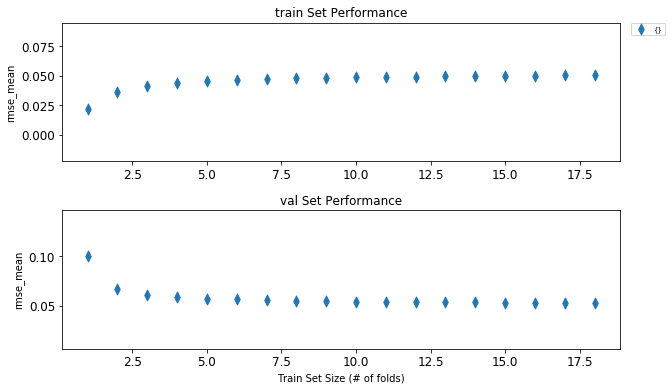

In [22]:
""" PROVIDED
LINEAR REGRESSION
Plot the mean (summary) train and validation set performances for 
each train size for the optimized metric. Use plot_best_params_by_size()

Note: for LinearRegression, there is only one parameter set.
"""
lnr_crossval.plot_best_params_by_size() 

(<Figure size 720x432 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x2b270e1bb6a0>,
       dtype=object))

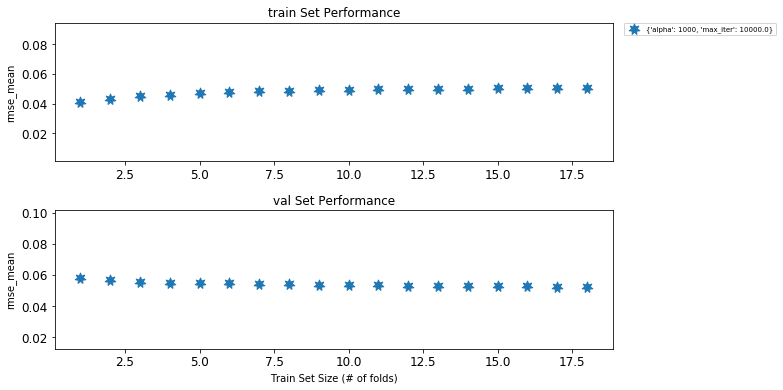

In [23]:
""" TODO
RIDGE
Plot the mean (summary) train and validation set performances for 
the best parameter set for each train size for the optimized
metrics. Use plot_best_params_by_size()
"""

r_crossval.plot_best_params_by_size()

(<Figure size 720x432 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x2b270e5fcd90>,
       dtype=object))

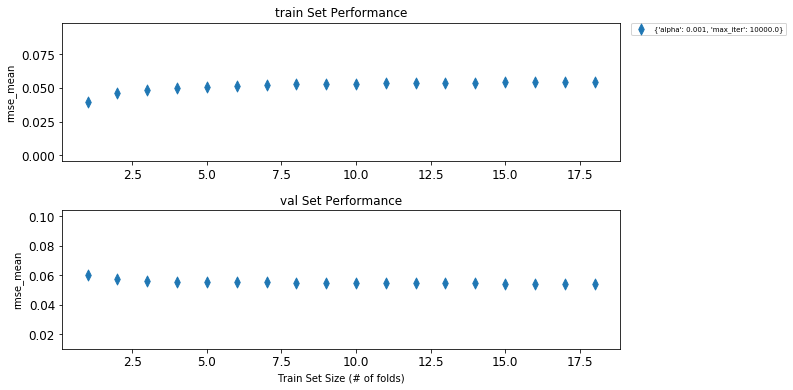

In [24]:
""" TODO
LASSO
Plot the mean (summary) train and validation set performances for 
the best parameter set for each train size for the optimized
metrics. Use plot_best_params_by_size()
"""

l_crossval.plot_best_params_by_size()

(<Figure size 720x432 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x2b270e47b430>,
       dtype=object))

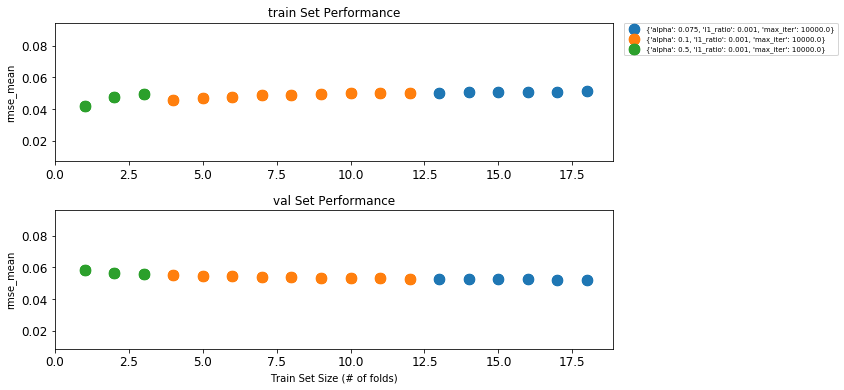

In [25]:
""" TODO
ELASTICNET
Plot the mean (summary) train and validation set performances for 
the best parameter set for each train size for the optimized
metrics. Use plot_best_params_by_size()
"""

crossval.plot_best_params_by_size()

### Plot Validation for All Parameter Sets for Each Size

(<Figure size 720x432 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x2b270e239220>,
       dtype=object))

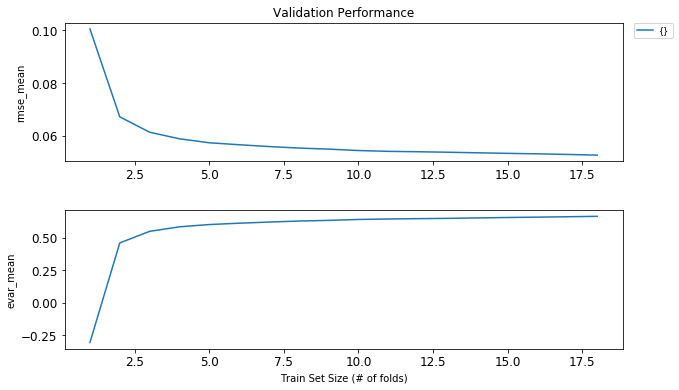

In [26]:
""" TODO
LINEAR REGRESSION
Plot the validation results for all parameter sets over all train 
sizes, for the specified metrics, rmse_mean and evar_mean
(this variable is declared above). Use plot_allparams_val()
"""

lnr_crossval.plot_allparams_val(metrics)

(<Figure size 720x432 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x2b270d9cb610>,
       dtype=object))

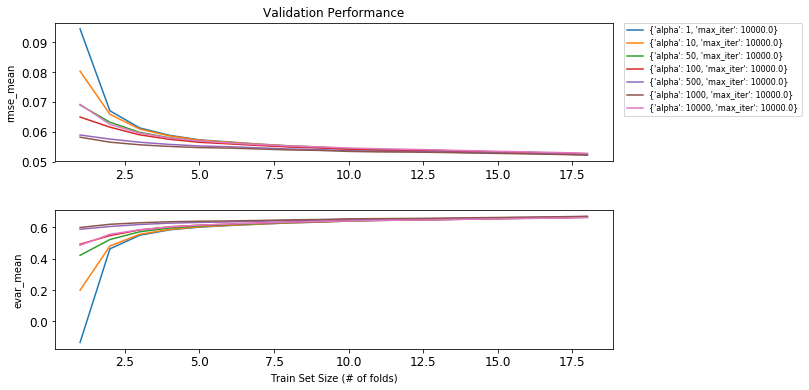

In [27]:
""" TODO
RIDGE
Plot the validation results for all parameter sets over all train 
sizes, for the specified metrics, rmse_mean and evar_mean
(this variable is declared above). Use plot_allparams_val()
"""

r_crossval.plot_allparams_val(metrics)

(<Figure size 720x432 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x2b270e014eb0>,
       dtype=object))

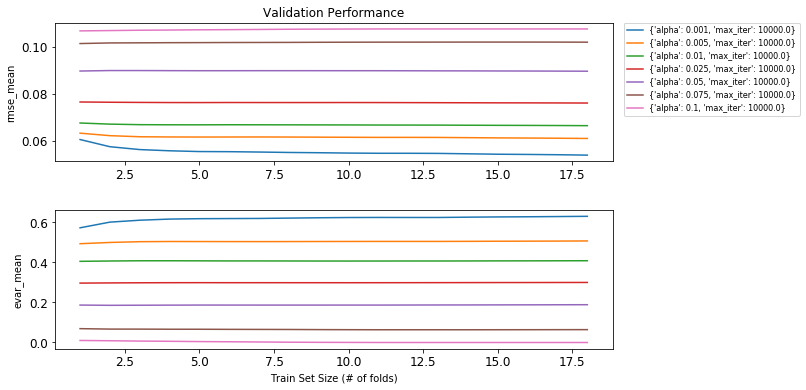

In [28]:
""" TODO
LASSO
Plot the validation results for all parameter sets over all train 
sizes, for the specified metrics, rmse_mean and evar_mean
(this variable is declared above). Use plot_allparams_val()
"""

l_crossval.plot_allparams_val(metrics)

(<Figure size 720x432 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x2b271aa2f910>,
       dtype=object))

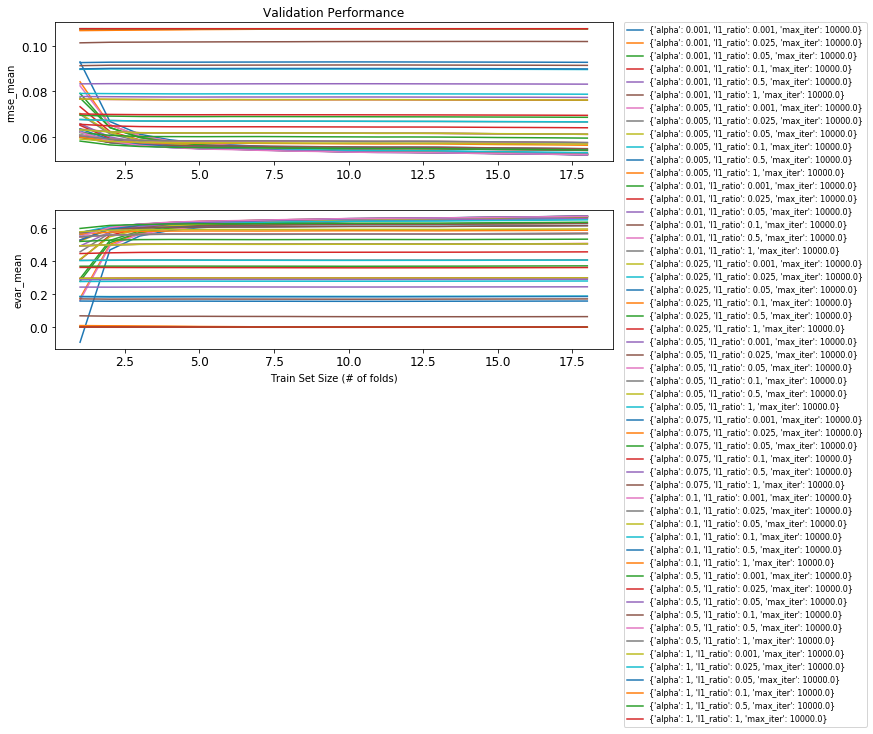

In [29]:
""" TODO
ELASTICNET
Plot the validation results for all parameter sets over all train 
sizes, for the specified metrics, rmse_mean and evar_mean
(this variable is declared above). Use plot_allparams_val()
"""

crossval.plot_allparams_val(metrics)

### Plot the TRAIN and VAL Set Performances

Train Set Size 8


(<Figure size 864x432 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x2b271f072b50>],
       dtype=object))

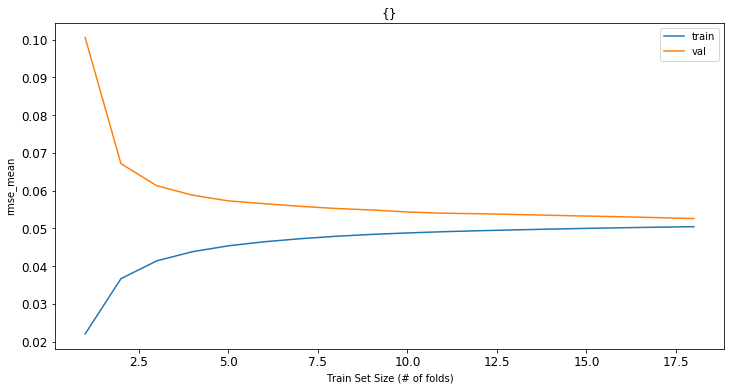

In [30]:
""" TODO
LINEAR REGRESSION
For the best parameter set for the train set size at 
size_idx=7 (this variable has already been declared above),
plot the TRAIN and VAL set performances using 
plot_param_train_val() for just the optimized metric.

Note: there is only one parameter set for the Linear model, 
thus paramidx=0
"""
print("Train Set Size", trainsizes[size_idx])

lnr_crossval.plot_param_train_val([lnr_crossval.opt_metric])

Train Set Size 8


(<Figure size 864x432 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x2b271f0ab820>],
       dtype=object))

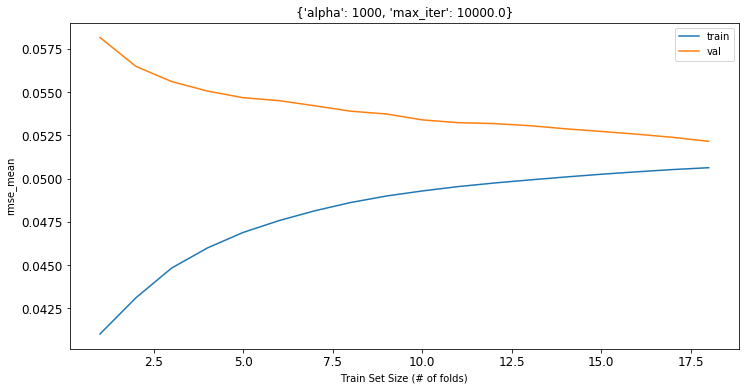

In [31]:
""" TODO
RIDGE
For the best parameter set for the train set size at 
size_idx=7 (this variable has already been declared above),
plot the TRAIN and VAL set performances using 
plot_param_train_val() for just the optimized metric

Use r_crossval.best_param_inds to get the desired parameter 
set index
"""
print("Train Set Size", trainsizes[size_idx])
r_crossval.plot_param_train_val([r_crossval.opt_metric], paramidx = r_crossval.best_param_inds[size_idx])


Train Set Size 8


(<Figure size 864x432 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x2b271f6f7d30>],
       dtype=object))

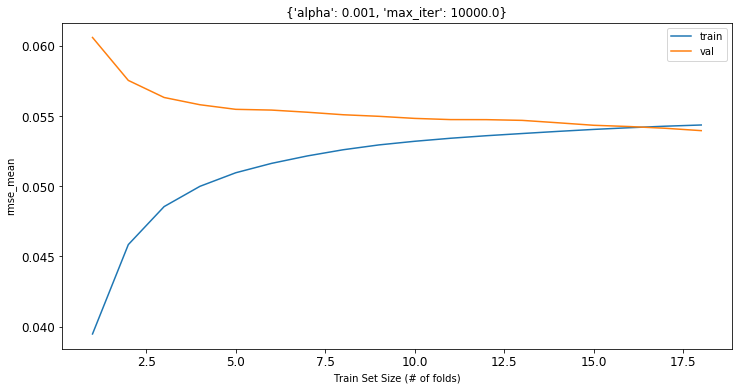

In [32]:
""" TODO
LASSO
For the best parameter set for the train set size at 
size_idx=7 (this variable has already been declared above),
plot the TRAIN and VAL set performances using 
plot_param_train_val() for just the optimized metric
"""
print("Train Set Size", trainsizes[size_idx])

bp_idx = l_crossval.best_param_inds[size_idx]
l_crossval.plot_param_train_val([l_crossval.opt_metric], paramidx=bp_idx)

Train Set Size 8


(<Figure size 864x432 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x2b271f707190>],
       dtype=object))

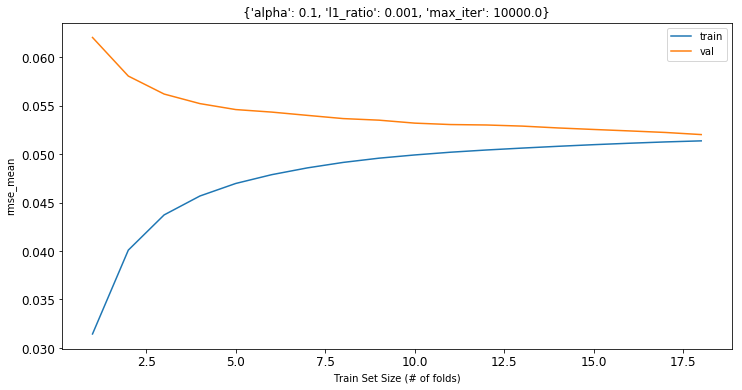

In [33]:
""" 
ELASTICNET
For the best parameter set for the train set size at 
size_idx=7 (this variable has already been declared above),
plot the TRAIN and VAL set performances using 
plot_param_train_val() for just the optimized metric
"""
print("Train Set Size", trainsizes[size_idx])
bp_idx = crossval.best_param_inds[size_idx]
crossval.plot_param_train_val([crossval.opt_metric], paramidx=bp_idx)

### Plot Performance over the Parameter Space

In [34]:
def plot_param_val_for_size(crossval, metric, alphas, sizeidx=0):
    ''' PROVIDED
    Plotting function for after grid_cross_validation(), 
    displaying the mean (summary) train and val set performances 
    for each alpha, given the size, for RIDGE and LASSO only

    PARAMS:
        crossval: cross validation object
        metric: summary metric to plot. '_mean' or '_std' must be 
                append to the end of the base metric name. These 
                base metric names are the keys in the dict returned
                by eval_func
        alphas: list of alpha values
        sizeidx: train size index

    RETURNS: the figure and axes handles
    '''
    sizes = crossval.trainsizes
    results = crossval.results
    best_param_inds = crossval.best_param_inds

    nalphas = len(alphas)

    nsizes = len(sizes)
    nmetrics = len(metrics)

    # Initialize the matrices for the curve
    Y_train = np.empty((nalphas,))
    Y_val = np.empty((nalphas,))

    # Obtain the mean performance for the curve
    for param_res in results:
        params = param_res['params']
        summary = param_res['summary']

        alpha_idx = alphas.index(params['alpha'])

        # Compute the mean for multiple outputs
        res_train = np.mean(summary['train'][metric][sizeidx, :])
        Y_train[alpha_idx] = res_train

        res_val = np.mean(summary['val'][metric][sizeidx, :])
        Y_val[alpha_idx] = res_val
    
    # Initialize figure plots
    fig = plt.figure(figsize=(12,2))
    for i, (Y, set_name) in enumerate(zip((Y_train, Y_val), 
                                          ('Training', 'Validation'))):
        # Plot
        ax = fig.add_subplot(1, 2, i+1)
        ax.plot(alphas, Y)
        title = "%s Performance, Train Size %d Folds" % (set_name, sizes[sizeidx])
        ax.set(title=title)
        ax.set(xlabel=r"$\alpha$", ylabel=metric)
    return fig


In [35]:
def plot_surface(xlist, ylist, Z_train, Z_val, ylabel, zlabel, 
                 elev=30, angle=45, title_suffix=""):
    ''' PROVIDED
    Helper plotting function. x-axis is always alpha
    
    REQUIRES: from mpl_toolkits.mplot3d import Axes3D

    PARAMS:
        xlist: list of x values
        ylist: list of y values
        Z_train: matrix of performance results from the training set
        Z_val: matrix of performance results from the validation set
        ylabel: y-axis label 
        zlabel: z-axis label
        elev: elevation of the 3D plot for the view
        angle: angle in degrees of the 3D plot for the view
        title_suffix: string to append to each subplot title

    RETURNS: the figure and axes handles
    '''
    # Initialize figure
    fig = plt.figure(figsize=(15,5))
    X, Y = np.meshgrid(xlist, ylist) 
    for i, (Z, set_name) in enumerate(zip((Z_train, Z_val), 
                                          ('Training', 'Validation'))):
        # Plot the surface
        ax = fig.add_subplot(1, 2, i+1, projection='3d')
        surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, 
                               linewidth=0, antialiased=False)
        title = "%s Performance %s" % (set_name, title_suffix)
        ax.view_init(elev=elev, azim=angle)
        ax.set(title=title)
        ax.set(xlabel=r"$\alpha$", ylabel=ylabel, zlabel=zlabel)
    return fig

In [36]:
def plot_param_val_surface_RL(crossval, metric, alphas, elev=30, angle=245):
    ''' PROVIDED
    Plotting function for after grid_cross_validation(), 
    displaying the mean (summary) train and val set performances 
    for each alpha, for all sizes, for RIDGE and LASSO only
    
    REQUIRES: from mpl_toolkits.mplot3d import Axes3D

    PARAMS:
        crossval: cross validation object
        metric: summary metric to plot. '_mean' or '_std' must be 
                append to the end of the base metric name. These 
                base metric names are the keys in the dict returned
                by eval_func
        alphas: list of alpha values
        elev: elevation of the 3D plot for the view
        angle: angle in degrees of the 3D plot for the view

    RETURNS: the figure and axes handles
    '''
    sizes = crossval.trainsizes
    results = crossval.results
    best_param_inds = crossval.best_param_inds

    nalphas = len(alphas)

    nsizes = len(sizes)
    nmetrics = len(metrics)

    # Initialize the matrices for the surface
    Z_train = np.empty((nsizes, nalphas))
    Z_val = np.empty((nsizes, nalphas))

    # Obtain the mean performance for the surface
    for param_res in results:
        params = param_res['params']
        summary = param_res['summary']

        alpha_idx = alphas.index(params['alpha'])

        # Compute the mean for multiple outputs
        res_train = np.mean(summary['train'][metric], axis=1)
        Z_train[:, alpha_idx] = res_train

        # Compute the mean for multiple outputs
        res_val = np.mean(summary['val'][metric], axis=1)
        Z_val[:, alpha_idx] = res_val
    
    fig = plot_surface(alphas, sizes, Z_train, Z_val, 'size (# of folds)', 
                       metric, elev, angle)
    return fig

In [37]:
def plot_param_val_surface_EN(crossval, metric, param_lists, 
                              sizeidx=0, elev=35, angle=280):
    ''' PROVIDED
    Plotting function for after grid_cross_validation(), 
    displaying the mean (summary) train and val set performances 
    for each alpha and l1_ratio, given the size, for the ELASTICNET
    
    REQUIRES: from mpl_toolkits.mplot3d import Axes3D

    PARAMS:
        crossval: cross validation object
        metric: summary metric to plot. '_mean' or '_std' must be 
                append to the end of the base metric name. These 
                base metric names are the keys in the dict returned
                by eval_func
        param_lists: dictionary of the list of alphas and l1_ratios
        sizeidx: train size index
        elev: elevation of the 3D plot for the view
        angle: angle in degrees of the 3D plot for the view

    RETURNS: the figure and axes handles
    '''
    sizes = crossval.trainsizes
    results = crossval.results
    best_param_inds = crossval.best_param_inds

    alphas = list(param_lists['alpha'])
    l1_ratios = list(param_lists['l1_ratio'])

    nalphas = len(alphas)
    nl1_ratios = len(l1_ratios)

    nsizes = len(sizes)
    nmetrics = len(metrics)

    # Initialize the matrices for the surface
    Z_train = np.empty((nl1_ratios, nalphas))
    Z_val = np.empty((nl1_ratios, nalphas))

    # Obtain the mean performance for the surface 
    for param_res in results:
        params = param_res['params']
        summary = param_res['summary']

        alpha_idx = alphas.index(params['alpha'])
        l1_idx = l1_ratios.index(params['l1_ratio'])

        # Compute the mean for multiple outputs
        res_train = np.mean(summary['train'][metric][sizeidx, :])
        Z_train[l1_idx, alpha_idx] = res_train

        res_val = np.mean(summary['val'][metric][sizeidx, :])
        Z_val[l1_idx, alpha_idx] = res_val
    
    fig = plot_surface(alphas, l1_ratios, Z_train, Z_val, 'l1_ratio', 
                       metric, elev, angle,', Size %d Folds' % sizes[sizeidx])
    return fig

In [38]:
""" PROVIDED
List the parameter sets explored for RIDGE
"""
r_crossval.paramsets

[{'alpha': 1, 'max_iter': 10000.0},
 {'alpha': 10, 'max_iter': 10000.0},
 {'alpha': 50, 'max_iter': 10000.0},
 {'alpha': 100, 'max_iter': 10000.0},
 {'alpha': 500, 'max_iter': 10000.0},
 {'alpha': 1000, 'max_iter': 10000.0},
 {'alpha': 10000, 'max_iter': 10000.0}]

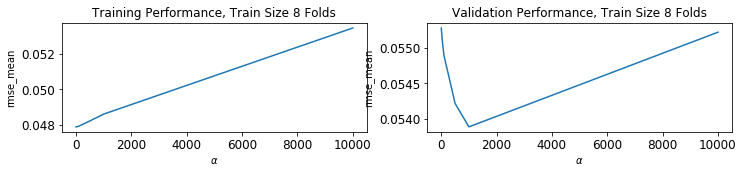

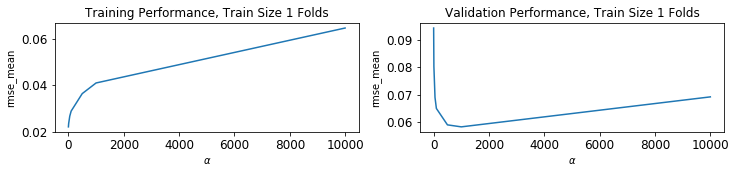

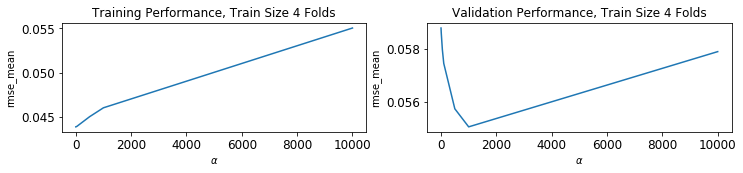

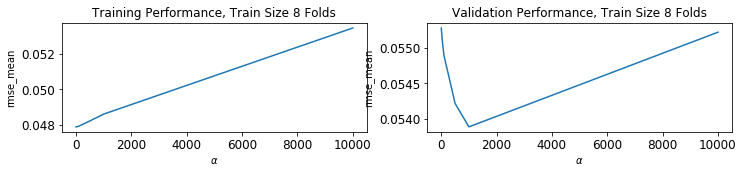

In [39]:
""" TODO
Plot the performance versus alpha for the RIDGE model
using plot_param_val_for_size() for size indices 0, 3, and 7, 
for the optimized metric (use r_crossval.opt_metric)
"""

alphas = [x['alpha'] for x in r_crossval.paramsets]
plot_param_val_for_size(r_crossval, r_crossval.opt_metric, alphas, sizeidx = 0)
plot_param_val_for_size(r_crossval, r_crossval.opt_metric, alphas, sizeidx = 3)
plot_param_val_for_size(r_crossval, r_crossval.opt_metric, alphas, sizeidx = 7)


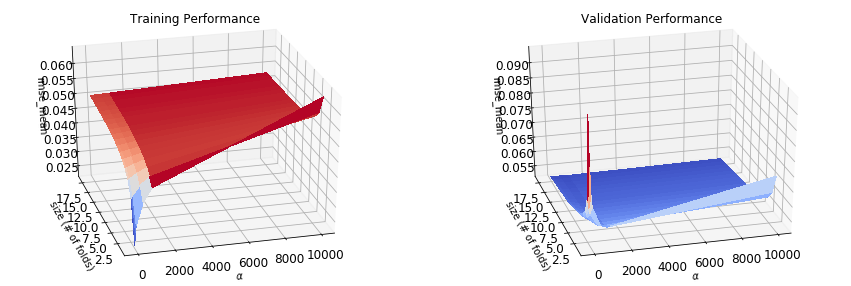

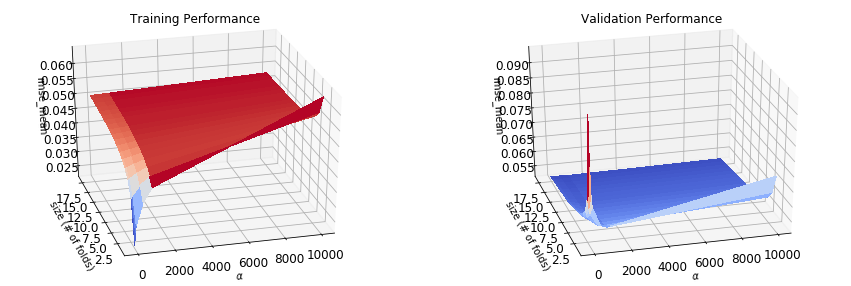

In [40]:
""" TODO
RIDGE
Use plot_param_val_surface_RL() to plot the surface of the training
and validation set performance versus alpha and size in the X and Y axes,
using the optimized metric
"""
# Feel free to adjust these to understand the shape of the surface
# Elevation of the plot
elev = 30
# Angle the plot is viewed
angle = 255

# TODO: Plot

plot_param_val_surface_RL(r_crossval, r_crossval.opt_metric, ridge_alphas, elev, angle)


In [41]:
""" PROVIDED
List the parameter sets explored for LASSO
"""
l_crossval.paramsets

[{'alpha': 0.001, 'max_iter': 10000.0},
 {'alpha': 0.005, 'max_iter': 10000.0},
 {'alpha': 0.01, 'max_iter': 10000.0},
 {'alpha': 0.025, 'max_iter': 10000.0},
 {'alpha': 0.05, 'max_iter': 10000.0},
 {'alpha': 0.075, 'max_iter': 10000.0},
 {'alpha': 0.1, 'max_iter': 10000.0}]

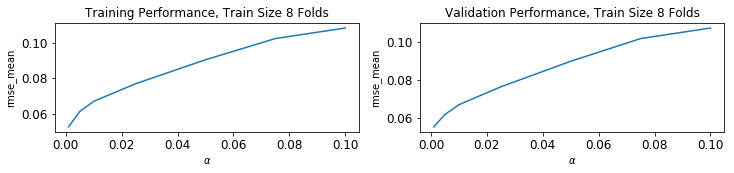

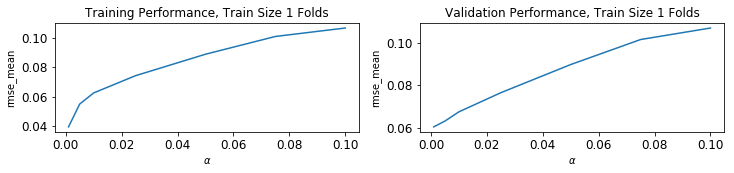

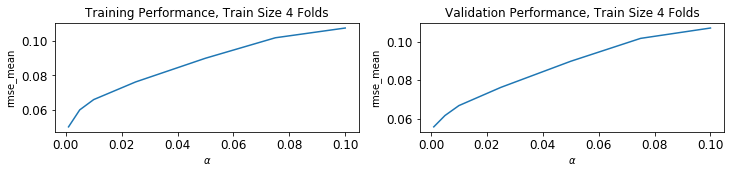

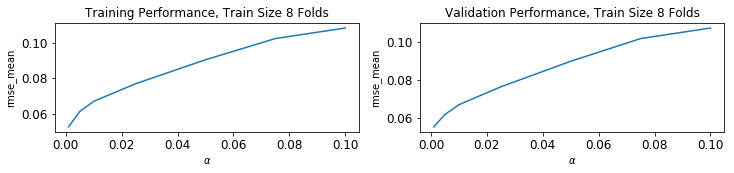

In [42]:
""" TODO
Plot the performance versus alpha for the LASSO model
using plot_param_val_for_size() for size indices 0, 3, and 7, 
for the optimized metric
"""
plot_param_val_for_size(l_crossval, l_crossval.opt_metric, lasso_alphas, sizeidx = 0)
plot_param_val_for_size(l_crossval, l_crossval.opt_metric, lasso_alphas, sizeidx = 3)
plot_param_val_for_size(l_crossval, l_crossval.opt_metric, lasso_alphas, sizeidx = 7)


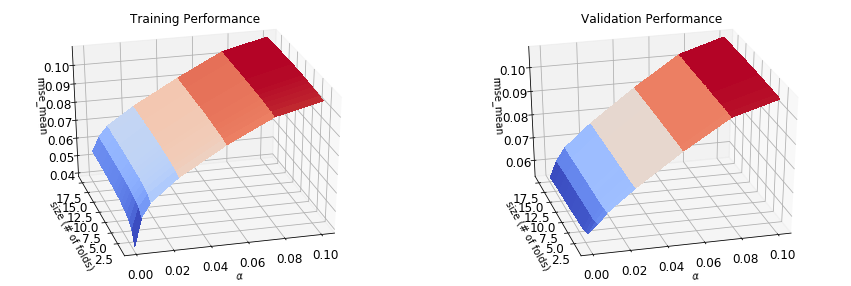

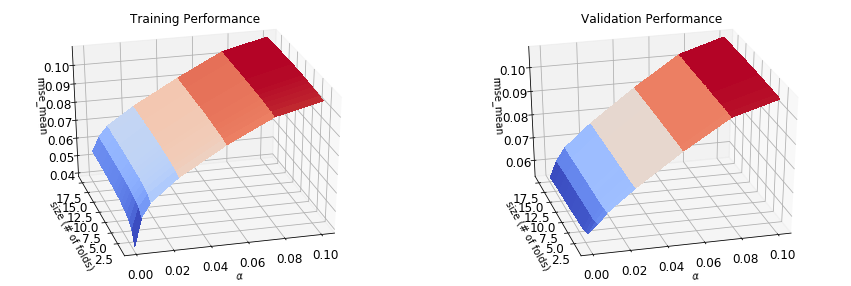

In [43]:
""" TODO
LASSO
Use plot_param_val_surface_RL() to plot the surface of the training
and validation set performance versus alpha and size in the X and Y axes,
using the optimized metric
"""
# Feel free to adjust these to understand the shape of the surface
# Elevation of the plot
elev = 30
# Angle the plot is viewed
angle = 255

# TODO: Plot
plot_param_val_surface_RL(l_crossval, l_crossval.opt_metric, lasso_alphas, elev, angle)


In [44]:
""" PROVIDED
List the parameter sets explored for ELASTICNET
"""
crossval.paramsets

[{'alpha': 0.001, 'l1_ratio': 0.001, 'max_iter': 10000.0},
 {'alpha': 0.001, 'l1_ratio': 0.025, 'max_iter': 10000.0},
 {'alpha': 0.001, 'l1_ratio': 0.05, 'max_iter': 10000.0},
 {'alpha': 0.001, 'l1_ratio': 0.1, 'max_iter': 10000.0},
 {'alpha': 0.001, 'l1_ratio': 0.5, 'max_iter': 10000.0},
 {'alpha': 0.001, 'l1_ratio': 1, 'max_iter': 10000.0},
 {'alpha': 0.005, 'l1_ratio': 0.001, 'max_iter': 10000.0},
 {'alpha': 0.005, 'l1_ratio': 0.025, 'max_iter': 10000.0},
 {'alpha': 0.005, 'l1_ratio': 0.05, 'max_iter': 10000.0},
 {'alpha': 0.005, 'l1_ratio': 0.1, 'max_iter': 10000.0},
 {'alpha': 0.005, 'l1_ratio': 0.5, 'max_iter': 10000.0},
 {'alpha': 0.005, 'l1_ratio': 1, 'max_iter': 10000.0},
 {'alpha': 0.01, 'l1_ratio': 0.001, 'max_iter': 10000.0},
 {'alpha': 0.01, 'l1_ratio': 0.025, 'max_iter': 10000.0},
 {'alpha': 0.01, 'l1_ratio': 0.05, 'max_iter': 10000.0},
 {'alpha': 0.01, 'l1_ratio': 0.1, 'max_iter': 10000.0},
 {'alpha': 0.01, 'l1_ratio': 0.5, 'max_iter': 10000.0},
 {'alpha': 0.01, 'l1_rati

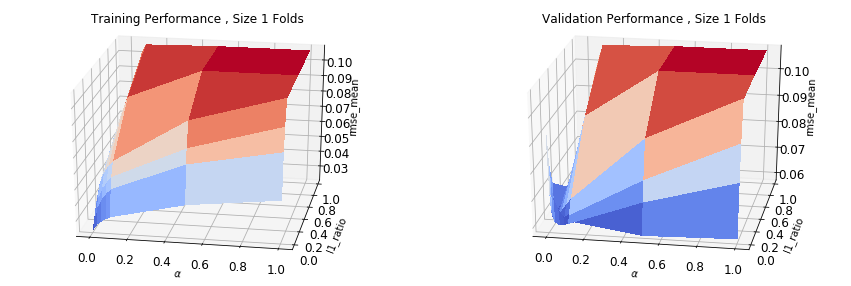

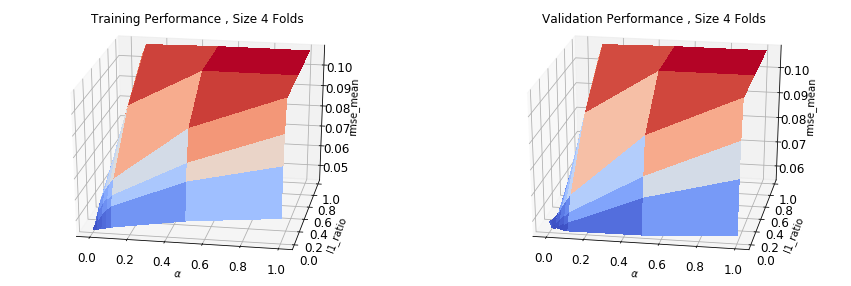

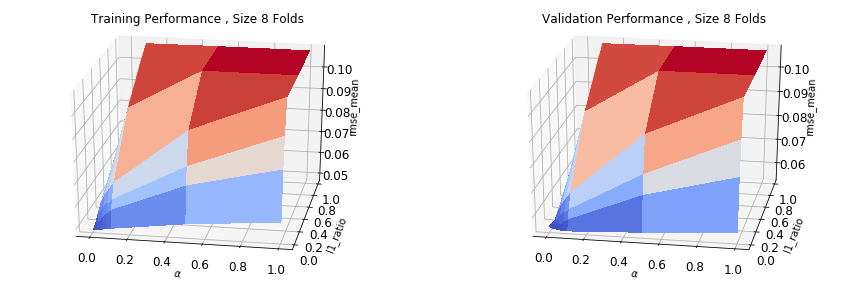

In [45]:
""" TODO
ELASTICNET
Use plot_param_val_surface_EN() to plot the surface of the training
and validation set performance versus alpha and l1_ratio in the X 
and Y axes for the size indices of 0, 3, and 7, for crossval.opt_metric
"""
# Feel free to adjust these to understand the shape of the surface
# Elevation of the plot
elev = 25
# Angle the plot is viewed
angle = 280

# TODO: Plot
for i in [0,3,7]:
    plot_param_val_surface_EN(crossval, crossval.opt_metric, param_lists, sizeidx=i, elev=elev, angle=angle)



### Paired t-tests
We can use paired t-tests to assess statistical significant differences between the mean test set performances of the models

In [46]:
""" PROVIDED
Obtain all the results for all the models
"""
# LinearRegression
lnr_all_results = lnr_crossval.results

# RIDGE
r_all_results = r_crossval.results

# LASSO
l_all_results = l_crossval.results

# ELASTICNET
all_results = crossval.results

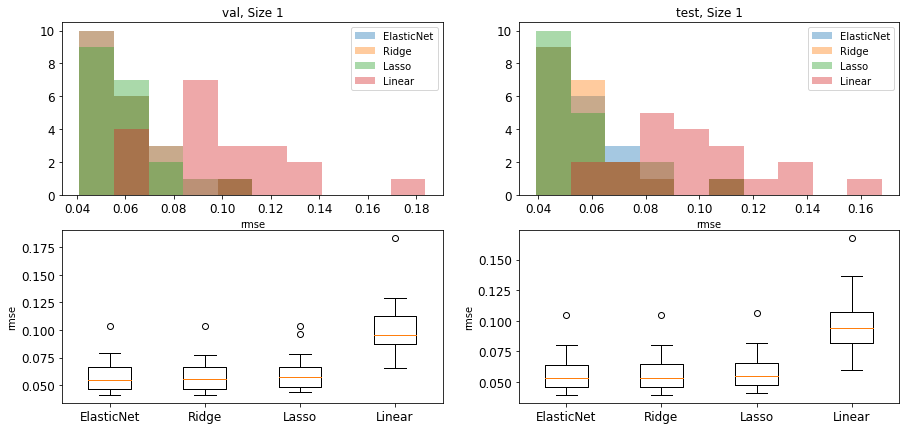

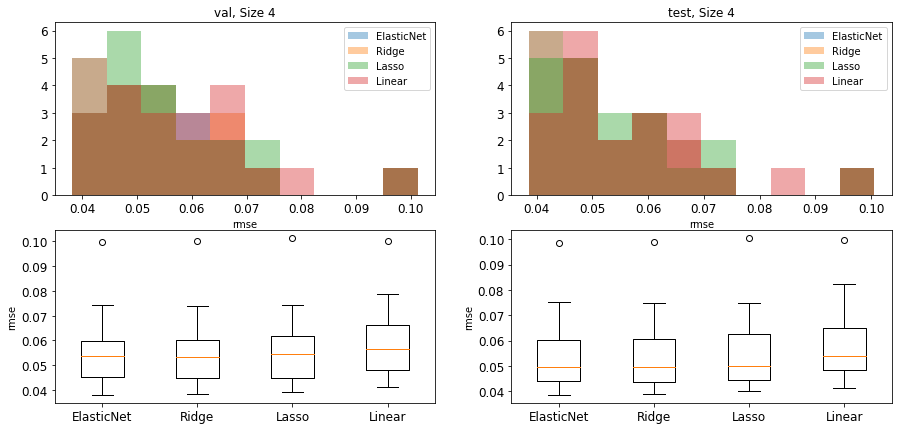

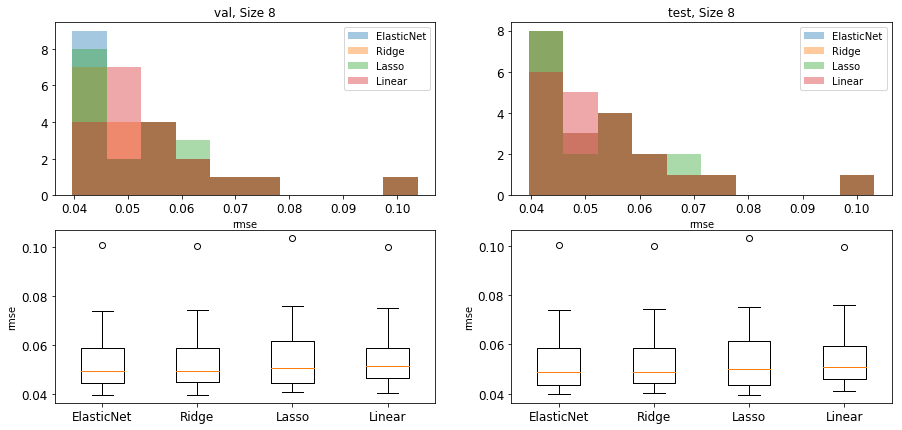

In [47]:
""" TODO
Complete the plotting code

Plot distributions of the Validation and Test scores from the
best parameter set for each base model for the corresponding 
size indices, [0, 3, 7]. The metric of interest is rmse.
These are the distribution of results from each rotation of 
the training set
"""
metric = 'rmse'
set_names = ['val', 'test']
nbins = 11

# Size indices
size_indices = [0, 3, size_idx]

for si in size_indices:
    # Obtain the index of the best parameter set for the size
    # RIDGE
    r_bp_idx = r_crossval.best_param_inds[si]
    # LASSO
    l_bp_idx = l_crossval.best_param_inds[si]
    # ELASTICNET
    bp_idx = crossval.best_param_inds[si]

    # Construct the figure
    fig, axs = plt.subplots(2, 2, figsize=(15,7))
    for i, set_name in enumerate(set_names):
        title = '%s, Size %d' % (set_name, trainsizes[si])

        # LINEAR
        # Note: there's only 1 parameter set for the Linear model
        lnr_res = lnr_all_results[0]['results'][si][set_name]
        lnr_scores = np.mean(lnr_res[metric], axis=1)

        # RIDGE
        # Obtain results for the best parameter set for the size
        ridge_res = r_all_results[r_bp_idx]['results'][si][set_name]
        # Compute the mean of the outputs for each data set rotation
        ridge_scores = np.mean(ridge_res[metric], axis=1)

        # LASSO
        lasso_res = l_all_results[l_bp_idx]['results'][si][set_name]
        lasso_scores = np.mean(lasso_res[metric], axis=1)
        
        # ELASTICNET
        res = all_results[bp_idx]['results'][si][set_name] # TODO
        elastic_scores =  np.mean(res[metric], axis=1)# TODO
        
        # Determine the edges for the bins in the histograms
        all_scores = np.concatenate((elastic_scores, ridge_scores, 
                                     lasso_scores, lnr_scores))
        mn = np.min(all_scores)
        mx = np.max(all_scores)
        bins = np.linspace(mn, mx, nbins)

        # Histograms
        # TODO: include the hist of the elastic net scores 
        
        axs[0, i].hist(elastic_scores, bins=bins, alpha=.4)
        axs[0, i].hist(ridge_scores, bins=bins, alpha=.4)
        axs[0, i].hist(lasso_scores, bins=bins, alpha=.4)
        axs[0, i].hist(lnr_scores, bins=bins, alpha=.4)
        axs[0, i].legend(['ElasticNet', 'Ridge', 'Lasso', 'Linear'])
        axs[0, i].set(title=title, xlabel=metric)
        
        # Boxplots
        axs[1, i].boxplot([elastic_scores, ridge_scores, lasso_scores, lnr_scores])
        axs[1, i].set_xticklabels(['ElasticNet', 'Ridge', 'Lasso', 'Linear'])
        axs[1, i].set(ylabel=metric)


In [48]:
""" TODO
Dependent Sample Paired t-test
Two-sided t-test for the null hypothesis that mean of the distribution
of differences between the two test performance distributions is zero 
"""
print("Train Set Size", trainsizes[size_idx])

# LINEAR
# Note: there's only 1 parameter set for the LinearRegression model
lnr_res = lnr_crossval.results[0]['results'][size_idx]['test']
lnr_test_res = np.mean(lnr_res[metric], axis=1)

# RIDGE
# Obtain index of best parameters for train size 8
r_bp_idx = r_crossval.best_param_inds[size_idx]
# Obtain all results for the best parameter set for train size 8
ridge_res = r_all_results[r_bp_idx]['results'][size_idx]['test']
# Compute the mean of the outputs for each data set rotation
ridge_test_res = np.mean(ridge_res[metric], axis=1)

# LASSO
l_bp_idx = l_crossval.best_param_inds[size_idx]
lasso_res = l_all_results[l_bp_idx]['results'][size_idx]['test']
lasso_test_res = np.mean(lasso_res[metric], axis=1)

# TODO: ELASTICNET
bp_idx = crossval.best_param_inds[size_idx]# TODO
net_res = all_results[bp_idx]['results'][size_idx]['test']# TODO
elastic_test_res = np.mean(net_res[metric], axis=1)# TODO

Train Set Size 8


In [49]:
""" TODO
ELASTICNET vs RIDGE
Execute the paired t-test to determine whether to reject the null hypothesis 
(i.e. H0) with 95% confidence. H0 is that the mean of the distribution of the 
differences between test scores for the best ELASTICNET model and the best RIDGE 
is zero, when using a training size of 8 (i.e. the size at index 7 of the 
trainsizes list). Display the t-statistic, the p-value, and the mean of the 
differences (i.e. mean(elastic_test_res - ridge_test_res))

Use stats.ttest_rel(). See the API reference above.
Do the same for all the pairing of models
"""
print(stats.ttest_rel(elastic_test_res, ridge_test_res))
print(np.mean(elastic_test_res - ridge_test_res))


Ttest_relResult(statistic=-2.4787147850144167, pvalue=0.022736733532476107)
-0.00021785532084971117


In [50]:
""" TODO
ELASTICNET vs LASSO
Execute the paired t-test
"""
print(stats.ttest_rel(elastic_test_res, lasso_test_res))
print(np.mean(elastic_test_res - lasso_test_res))


Ttest_relResult(statistic=-4.3151954381636095, pvalue=0.00037323234323962415)
-0.0014263082520257705


In [51]:
""" TODO
ELASTICNET vs LinearRegression
Execute the paired t-test
"""
print(stats.ttest_rel(elastic_test_res, lnr_test_res))
print(np.mean(elastic_test_res - lnr_test_res))


Ttest_relResult(statistic=-4.873596012694302, pvalue=0.00010549817316970218)
-0.0015881764958851166


In [52]:
""" TODO
RIDGE vs LASSO
Execute the paired t-test
"""
print(stats.ttest_rel(ridge_test_res, lasso_test_res))
print(np.mean(ridge_test_res - lasso_test_res))


Ttest_relResult(statistic=-2.9120174293543895, pvalue=0.008939372406479561)
-0.0012084529311760593


In [53]:
""" TODO
RIDGE vs LinearRegression
Execute the paired t-test
"""
print(stats.ttest_rel(ridge_test_res, lnr_test_res))
print(np.mean(ridge_test_res - lnr_test_res))


Ttest_relResult(statistic=-5.610555129622476, pvalue=2.071569385430269e-05)
-0.0013703211750354053


In [54]:
""" TODO
LASSO vs LinearRegression
Execute the paired t-test
"""
print(stats.ttest_rel(lasso_test_res, lnr_test_res))
print(np.mean(lasso_test_res - lnr_test_res))


Ttest_relResult(statistic=-0.2528166363086273, pvalue=0.8031249544779376)
-0.00016186824385934598


# DISCUSSION
For each question write one brief paragraph of discussion:

1. Interpret the meaning of the t-test results using 95% confidence. Discuss the statistical meaning as well as the practical interpretation of the results in the context of the data set.<br/>
A) 
for all model comparisions except LASSO vs LinearRegression:
we reject the null hypothesis as p-values < 0.025 meaning the assumption that the mean of the distribution of the differences between test performance is zero is incorrect. The mean of the distribution of the differences between test performance is statistically different than zero. The models performs differently from each other. <br/>for LASSO vs LinearRegression:
we do not reject null hypothesis. the models perform similarly.

2. For the Elastic Net Model, discuss the differences in the surfaces between the train sizes of 1, 4, and 8 folds, for both the training and validation sets.
<br/>
As we can see from the surface graphs of the train sizes of 1, 4, and 8 folds, there is not much change differences in the surfaces between for the training that contain two parameter sets.<br/>
But, for validitaion surface the 1 fold validation seems to be overfit the data between alpha = 0.0 to 0.1 and l1_ration = 0.2 to 0.6(the values are not visible from surface this is just an approximation). The model is able to capture the general trend  as we increase the parameter(alpha and l1_ration). <br/>

If we increase the number of folds (4,8) the model is performing well without overfitting.

3. For each of the train set sizes of 1, 4, and 8 folds, which model (Linear, Lasso, Ridge, or ElasticNet) and corresponding parameter set would you select and why? Specify which model and parameter set for each size. For each size, use plot_param_train_val() to view the train, val, and test sets of the chosen model(s). Remember, selections should be made based on the validation performance.<br/>
I select
for size 1:
ridge with parameters alpha = 0.1 and l1_ratio = 0.001
for size 4:
Elastice net with parameters alpha = 0.1 and l1_ratio = 0.001
for size 8
Elastice net with parameters alpha = 0.1 and l1_ratio = 0.001

because the train and val performance looks similar.


Train Set Size 1
Train Set Size 4
Train Set Size 8


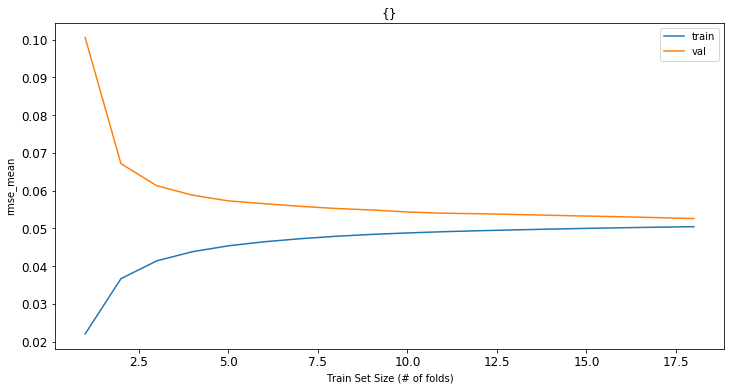

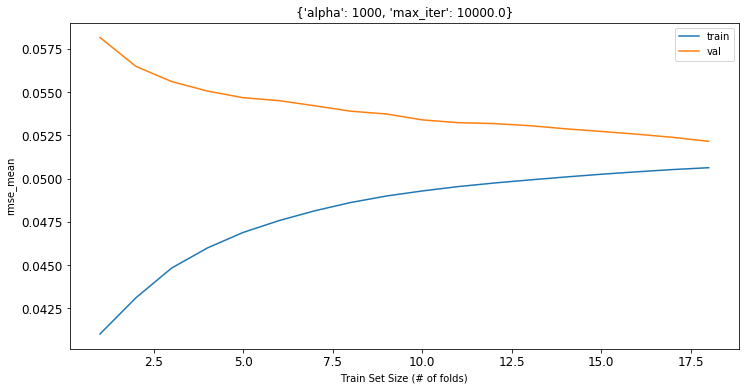

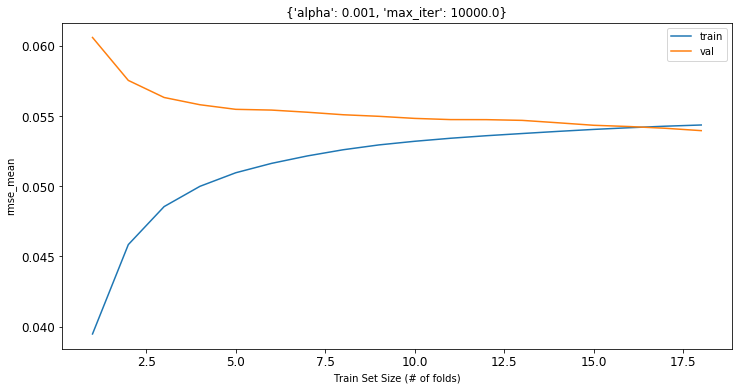

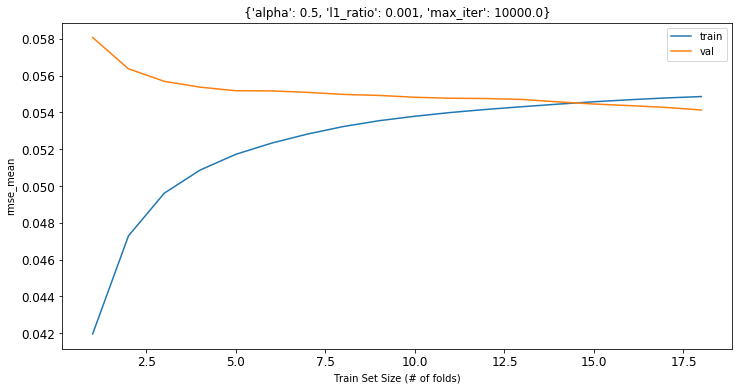

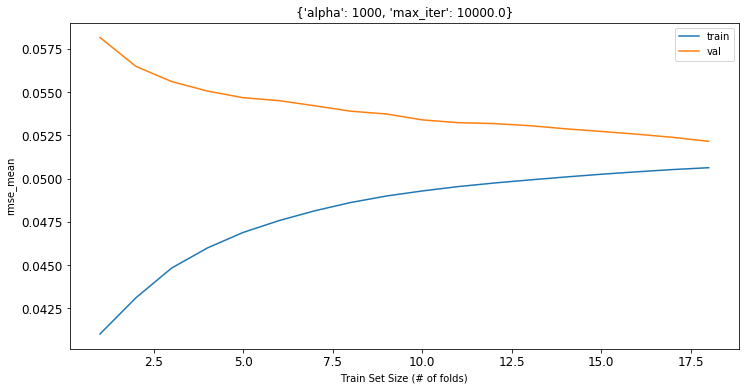

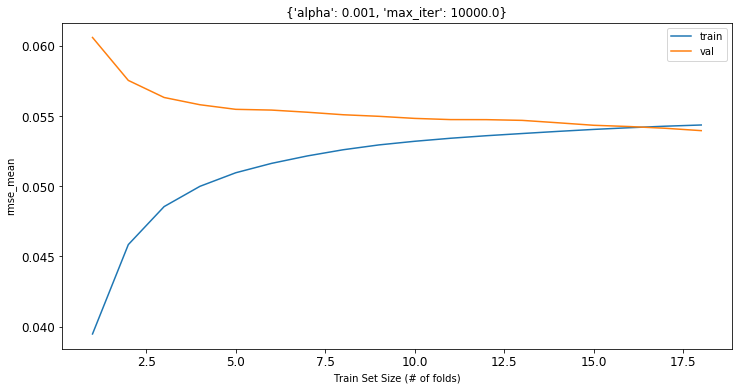

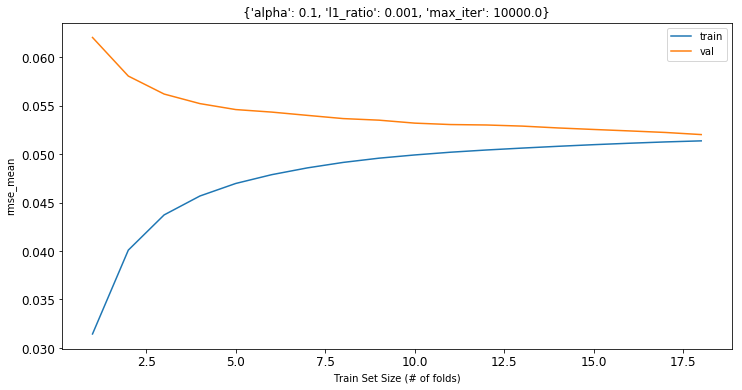

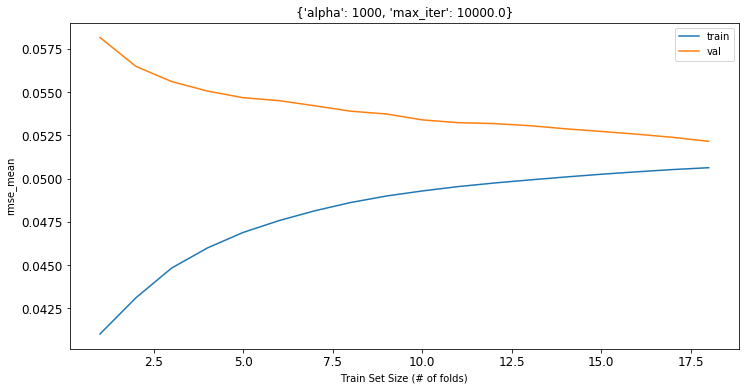

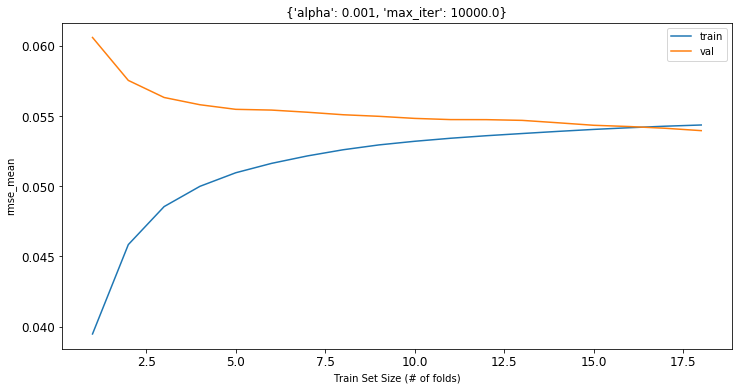

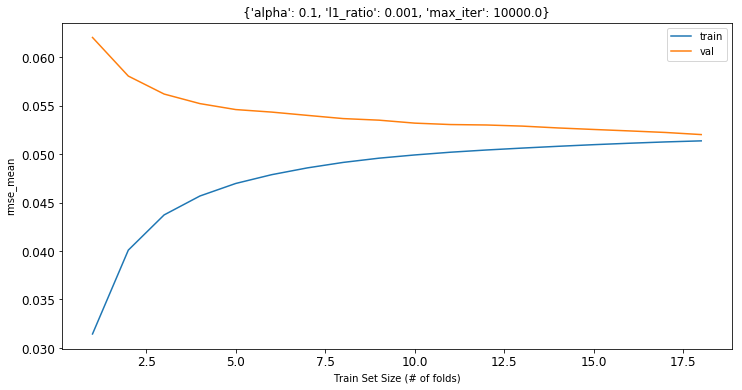

In [59]:
""" TODO
Discussion question 3 plots
"""
lnr_crossval.plot_param_train_val([lnr_crossval.opt_metric])

for i in [0,3,7]:
    
    print("Train Set Size", trainsizes[i])
    r_crossval.plot_param_train_val([r_crossval.opt_metric], paramidx= r_crossval.best_param_inds[i])

    l_crossval.plot_param_train_val([l_crossval.opt_metric], paramidx= l_crossval.best_param_inds[i])

    crossval.plot_param_train_val([crossval.opt_metric], paramidx= crossval.best_param_inds[i])


